In [1]:
import pylcp
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants as const
from sympy.physics.wigner import wigner_3j, wigner_6j, wigner_9j
import time
import pathos
from sympy import Symbol
import numbers
from scipy.optimize import bisect
from cmcrameri import cm as scicmap

In [2]:
gamma = 2*np.pi*84e6 # Hz
k = 2*np.pi/227.5e-9 # m^-1

t_unit = 1/gamma
#t_unit = 1e-1

m_unit = 1/k
#m_unit = 1e-9

velocity_unit = m_unit/t_unit
accel_unit = m_unit/t_unit**2
Hz_unit = 1/t_unit
Js_unit = const.hbar # kg m^2/s
mass_unit = Js_unit*t_unit/m_unit**2
HzperT_unit = const.value("Bohr magneton")/(Js_unit)
T_unit = Hz_unit/HzperT_unit
amu_unit = mass_unit/1.66e-27
cm_unit = m_unit/1e-2
F_unit = mass_unit*m_unit/t_unit**2
I_sat = (np.pi*const.h*const.c*gamma)/(3*227.5e-9**3) # W/m^2

In [3]:
print(t_unit)
print(cm_unit)
print(velocity_unit)
print(accel_unit)

1.8947017034749446e-09
3.6207749553406186e-06
19.11
10086020382.496958


In [4]:
ksim=k*m_unit
gammasim=gamma/Hz_unit
print(ksim)
print(gammasim)

1.0
1.0000000000000002


In [5]:
# (F1, F) IAl = 5/2, IF = 1/2, F1 = J + IAl, F = F1 + IF
labels = [(3/2,1),(3/2,2),(5/2,2),(5/2,3),(7/2,3),(7/2,4)]
full_labels = np.concatenate([[(i[0], i[1], j) for j in np.arange(-i[1],i[1]+1,1)] for i in labels])

In [6]:
mu_q = {}
d_q = {}
H0 = {}

In [7]:
mu_q['X(v=0)'] = np.zeros((3,full_labels.shape[0],full_labels.shape[0]))
mu_q['X(v=1)'] = np.zeros((3,full_labels.shape[0],full_labels.shape[0]))
H0['X(v=0)'] = (2*np.pi/Hz_unit)*np.diag(np.concatenate([[11.235e6]*8, [0]*12, [7.914e6]*16]))
H0['X(v=1)'] = (2*np.pi/Hz_unit)*np.diag(np.concatenate([[11.235e6]*8, [0]*12, [7.914e6]*16]))
# H0['X(v=1)'] = np.zeros((full_labels.shape[0],full_labels.shape[0]))
H0['A(v=0)'] = (2*np.pi/Hz_unit)*np.diag([9.06039e7, 9.06039e7, 9.06039e7, 0., 0., 0., 0., 0., 2.09987e8, 2.09987e8, 2.09987e8, 2.09987e8, 2.09987e8, 1.99498e8, 1.99498e8, 1.99498e8, 1.99498e8, 1.99498e8, 1.99498e8, 1.99498e8, 3.61039e8, 3.61039e8, 3.61039e8, 3.61039e8, 3.61039e8, 3.61039e8, 3.61039e8, 4.36374e8, 4.36374e8, 4.36374e8, 4.36374e8, 4.36374e8, 4.36374e8, 4.36374e8, 4.36374e8, 4.36374e8])

In [8]:
# def AState_mu_q(J, lbls, I1, I2):
#     def matrix_element(p,F1,F,MF,F1p,Fp,MFp):
#         return float((-1)**(F-MF+F1p+F+I2+1+J+F1+I1+1+J-1)*np.sqrt((2*F+1)*(2*Fp+1)*(2*F1+1)*(2*F1p+1)*(2*J+1)*(2*J+1))*wigner_3j(F,1,Fp,-MF,p,MFp)*wigner_3j(J,1,J,-1,0,1)*wigner_6j(F1p,Fp,I2,F,F1,1)*wigner_6j(J,F1p,I1,F1,J,1))
    
#     return np.array([[[matrix_element(i,*l2,*l1) for l2 in lbls] for l1 in lbls] for i in [-1,0,1]])
def AState_mu_q(J, lbls, I1, I2): # for the A1Pi state
    Lambda = 1
    def matrix_element(p,F1,F,MF,F1p,Fp,MFp):
        return float((-1)**(F-MF)*wigner_3j(F,1,Fp,-MF,p,MFp)*np.sqrt(3*(2*F+1)*(2*Fp+1))*wigner_9j(F,Fp,1,F1,F1p,1,I2,I2,0)*np.sqrt(3*(2*F1+1)*(2*F1p+1))*wigner_9j(F1,F1p,1,J,J,1,I1,I1,0)*Lambda*(-1)**(J-Lambda)*np.sqrt((2*J+1)*(2*J+1))*wigner_3j(J,1,J,-Lambda,0,Lambda))
    return np.array([[[matrix_element(i,*l2,*l1) for l2 in lbls] for l1 in lbls] for i in [-1,0,1]])

In [9]:
def H0_Singlet(J, Lambda, state_labels, I1, I2):
    def _delta(i, j, eps = 1e-6):
        return abs(i-j) < eps
    def nuclear_rotation(F1, F, MF, F1p, Fp, MFp):
        return (-1)**(J+F1+I1+J-Lambda)*_delta(F,Fp)*_delta(F1,F1p)*wigner_6j(I2, F1p, I1, F1, J, 1)*\
               wigner_3j(J, 1, J, -Lambda, 0, Lambda)*np.sqrt((2*J+1)*(2*J+1)*I1*(I1+1)*(2*I1))
        pass
        
    pass

In [10]:
mu_q['A(v=0)'] = AState_mu_q(1, full_labels, 5/2,1/2)

In [11]:
dijq = np.array([[[0, 0.35304819526102776, 0], [0, 0, -0.35304819526102776], [0, 0, 0], [0.05581760941791929, 0, 0], [0, -0.03946901012903283, 0], [0, 0, 0.02278744362264517], [0, 0, 0], [0, 0, 0], [0.6677710584047486, 0, 0], [0, -0.4721854436781158, 0], [0, 0, 0.272616393014983], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0.35304819526102776, 0, 0], [0, 0., 0], [0, 0, -0.35304819526102776], [0, 0, 0], [0.03946901012903283, 0, 0], [0, -0.04557488724529034, 0], [0, 0, 0.03946901012903283], [0, 0, 0], [0, 0, 0], [0.4721854436781158, 0, 0], [0, -0.545232786029966, 0], [0, 0, 0.4721854436781158], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0.35304819526102776, 0, 0], [0, -0.35304819526102776, 0], [0, 0, 0], [0, 0, 0], [0.02278744362264517, 0, 0], [0, -0.03946901012903283, 0], [0, 0, 0.05581760941791929], [0, 0, 0], [0, 0, 0], [0.272616393014983, 0, 0], [0, -0.4721854436781158, 0], [0, 0, 0.6677710584047486], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, -0.17449995614010205], [0, 0, 0], [0, 0, 0], [0, -0.4577750113891102, 0], [0, 0, 0.32369581481098886], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, -0.023497211103777865, 0], [0, 0, 0.01661503731045317], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.6357140230701519, 0, 0], [0, 0.3670296623471722, 0], [0, 0, -0.16414065495341443], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.24677980589841625, 0, 0], [0, -0.14247838736601423, 0], [0, 0, 0.06371827189499102], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, -0.12339010230342129, 0], [0, 0, -0.12339010230342129], [0, 0, 0], [-0.32369581481098886, 0, 0], [0, -0.2288875056945551, 0], [0, 0, 0.3964447890806802], [0, 0, 0], [0, 0, 0], [-0.01661503731045317, 0, 0], [0, -0.011748605551888933, 0], [0, 0, 0.020349181733957424], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.5190583262845886, 0, 0], [0, 0.4642598807438424, 0], [0, 0, -0.28429995396694585], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.20149486775806477, 0, 0], [0, -0.18022248856974538, 0], [0, 0, 0.11036328429261245], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[-0.07123930878021573, 0, 0], [0, -0.14247861756043145, 0], [0, 0, -0.07123930878021573], [0, 0, 0], [-0.3964447890806802, 0, 0], [0, 0., 0], [0, 0, 0.3964447890806802], [0, 0, 0], [0, 0, 0], [-0.020349181733957424, 0, 0], [0, 0., 0], [0, 0, 0.020349181733957424], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.40206085068210146, 0, 0], [0, 0.49242196486024326, 0], [0, 0, -0.40206085068210146], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.15607725343465012, 0, 0], [0, -0.19115481568497303, 0], [0, 0, 0.15607725343465012], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [-0.12339010230342129, 0, 0], [0, -0.12339010230342129, 0], [0, 0, 0], [0, 0, 0], [-0.3964447890806802, 0, 0], [0, 0.2288875056945551, 0], [0, 0, 0.32369581481098886], [0, 0, 0], [0, 0, 0], [-0.020349181733957424, 0, 0], [0, 0.011748605551888933, 0], [0, 0, 0.01661503731045317], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.28429995396694585, 0, 0], [0, 0.4642598807438424, 0], [0, 0, -0.5190583262845886], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.11036328429261245, 0, 0], [0, -0.18022248856974538, 0], [0, 0, 0.20149486775806477], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [-0.17449995614010205, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.32369581481098886, 0, 0], [0, 0.4577750113891102, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.01661503731045317, 0, 0], [0, 0.023497211103777865, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.16414065495341443, 0, 0], [0, 0.3670296623471722, 0], [0, 0, -0.6357140230701519], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.06371827189499102, 0, 0], [0, -0.14247838736601423, 0], [0, 0, 0.24677980589841625], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, -0.6480569797436475], [0, 0, 0], [0, 0, 0], [0, 0.10267769371443052, 0], [0, 0, -0.07260409350206916], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, -0.23768910631140486, 0], [0, 0, 0.16807157888696458], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.259538377295067, 0, 0], [0, -0.1498445519963456, 0], [0, 0, 0.06701252086436613], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.5238464644064819, 0, 0], [0, -0.30244289723911605, 0], [0, 0, 0.1352565755077294], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, -0.45824548497200623, 0], [0, 0, -0.45824548497200623], [0, 0, 0], [0.07260409350206916, 0, 0], [0, 0.05133884685721526, 0], [0, 0, -0.0889214911586946], [0, 0, 0], [0, 0, 0], [-0.16807157888696458, 0, 0], [0, -0.11884455315570243, 0], [0, 0, 0.20584480426849677], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.21191219768095237, 0, 0], [0, -0.18954003171039313, 0], [0, 0, 0.11606909088035157], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.42771884711897024, 0, 0], [0, -0.382563366966343, 0], [0, 0, 0.23427126083716351], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[-0.26456815410351836, 0, 0], [0, -0.5291363082070367, 0], [0, 0, -0.26456815410351836], [0, 0, 0], [0.0889214911586946, 0, 0], [0, 0., 0], [0, 0, -0.0889214911586946], [0, 0, 0], [0, 0, 0], [-0.20584480426849677, 0, 0], [0, 0., 0], [0, 0, 0.20584480426849677], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.16414648249530853, 0, 0], [0, -0.20103756259309835, 0], [0, 0, 0.16414648249530853], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.33130959435016155, 0, 0], [0, -0.4057697265231882, 0], [0, 0, 0.33130959435016155], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [-0.45824548497200623, 0, 0], [0, -0.45824548497200623, 0], [0, 0, 0], [0, 0, 0], [0.0889214911586946, 0, 0], [0, -0.05133884685721526, 0], [0, 0, -0.07260409350206916], [0, 0, 0], [0, 0, 0], [-0.20584480426849677, 0, 0], [0, 0.11884455315570243, 0], [0, 0, 0.16807157888696458], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.11606909088035157, 0, 0], [0, -0.18954003171039313, 0], [0, 0, 0.21191219768095237], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.23427126083716351, 0, 0], [0, -0.382563366966343, 0], [0, 0, 0.42771884711897024], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [-0.6480569797436475, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.07260409350206916, 0, 0], [0, -0.10267769371443052, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.16807157888696458, 0, 0], [0, 0.23768910631140486, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.06701252086436613, 0, 0], [0, -0.1498445519963456, 0], [0, 0, 0.259538377295067], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.1352565755077294, 0, 0], [0, -0.30244289723911605, 0], [0, 0, 0.5238464644064819], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, -0.662067951237325], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0.1798085031690214], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, -0.14955337350005393, 0], [0, 0, 0.08634468044847278], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0.17609495930165456, 0], [0, 0, -0.10166847215574645], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.5965940533333333, 0, 0], [0, -0.29829702666666663, 0], [0, 0, 0.11274567848428604], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, -0.38224510986869364, 0], [0, 0, -0.5405762185271004], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0.1038124877072182, 0], [0, 0, 0.14681302805923818], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.08634468044847278, 0, 0], [0, -0.09970224900003596, 0], [0, 0, 0.11147050313684542], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.10166847215574645, 0, 0], [0, 0.11739663953443638, 0], [0, 0, -0.1312534331645195], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.516665605933395, 0, 0], [0, -0.39056248693721735, 0], [0, 0, 0.19528124346860867], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.17094520994665494, 0, 0], [0, -0.483506068658551, 0], [0, 0, -0.41872853834224816], [0, 0, 0], [0, 0, 0], [0.046426355885340234, 0, 0], [0, 0.13131356428921623, 0], [0, 0, 0.11372088253594233], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.11147050313684542, 0, 0], [0, -0.04985112450001798, 0], [0, 0, 0.12210981812900125], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.1312534331645195, 0, 0], [0, 0.05869831976721819, 0], [0, 0, -0.143780932188408], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.4366621351264958, 0, 0], [0, -0.4366621351264958, 0], [0, 0, 0.2761693829903888], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.2960857889381349, 0, 0], [0, -0.5128356298399648, 0], [0, 0, -0.2960857889381349], [0, 0, 0], [0, 0, 0], [0.08041280720368364, 0, 0], [0, 0.1392790676560207, 0], [0, 0, 0.08041280720368364], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.12210981812900125, 0, 0], [0, 0., 0], [0, 0, 0.12210981812900125], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.143780932188408, 0, 0], [0, 0., 0], [0, 0, -0.143780932188408], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.35653314035138445, 0, 0], [0, -0.4509827139371442, 0], [0, 0, 0.35653314035138445], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.41872853834224816, 0, 0], [0, -0.483506068658551, 0], [0, 0, -0.17094520994665494], [0, 0, 0], [0, 0, 0], [0.11372088253594233, 0, 0], [0, 0.13131356428921623, 0], [0, 0, 0.046426355885340234], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.12210981812900125, 0, 0], [0, 0.04985112450001798, 0], [0, 0, 0.11147050313684542], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.143780932188408, 0, 0], [0, -0.05869831976721819, 0], [0, 0, -0.1312534331645195], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.2761693829903888, 0, 0], [0, -0.4366621351264958, 0], [0, 0, 0.4366621351264958], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.5405762185271004, 0, 0], [0, -0.38224510986869364, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.14681302805923818, 0, 0], [0, 0.1038124877072182, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.11147050313684542, 0, 0], [0, 0.09970224900003596, 0], [0, 0, 0.08634468044847278], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.1312534331645195, 0, 0], [0, -0.11739663953443638, 0], [0, 0, -0.10166847215574645], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.19528124346860867, 0, 0], [0, -0.39056248693721735, 0], [0, 0, 0.516665605933395], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.662067951237325, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.1798085031690214, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.08634468044847278, 0, 0], [0, 0.14955337350005393, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.10166847215574645, 0, 0], [0, -0.17609495930165456, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.11274567848428604, 0, 0], [0, -0.29829702666666663, 0], [0, 0, 0.5965940533333333]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, -0.19468707351513623], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, -0.549834326422256], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, -0.14055931028242558, 0], [0, 0, 0.08115195562866655], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, -0.6778630811094402, 0], [0, 0, 0.3913644323522444], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.13074899566666665, 0, 0], [0, -0.06537449783333332, 0], [0, 0, 0.024709237621818696], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, -0.11240263430170437, 0], [0, 0, -0.1589613298759336], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, -0.3174469963695861, 0], [0, 0, -0.44893784760047134], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.08115195562866655, 0, 0], [0, -0.0937062068549504, 0], [0, 0, 0.10476672422066294], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.3913644323522444, 0, 0], [0, -0.45190872073962685, 0], [0, 0, 0.5052493095993873], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.11323195176663484, 0, 0], [0, -0.08559530995456473, 0], [0, 0, 0.042797654977282364], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.05026798622973212, 0, 0], [0, -0.14217933575854227, 0], [0, 0, -0.12313091666009486], [0, 0, 0], [0, 0, 0], [-0.14196661262710472, 0, 0], [0, -0.4015422179628379, 0], [0, 0, -0.34774576144776576], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.10476672422066294, 0, 0], [0, -0.0468531034274752, 0], [0, 0, 0.11476619626315987], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.5052493095993873, 0, 0], [0, -0.22595436036981342, 0], [0, 0, 0.5534728880629918], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.0956984658067856, 0, 0], [0, -0.0956984658067856, 0], [0, 0, 0.06052502410663711], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.08706670614406871, 0, 0], [0, -0.15080395868919635, 0], [0, 0, -0.08706670614406871], [0, 0, 0], [0, 0, 0], [-0.24589338604859465, 0, 0], [0, -0.42589983788131414, 0], [0, 0, -0.24589338604859465], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.11476619626315987, 0, 0], [0, 0., 0], [0, 0, 0.11476619626315987], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.5534728880629918, 0, 0], [0, 0., 0], [0, 0, 0.5534728880629918], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.07813747013126932, 0, 0], [0, -0.09883695048727478, 0], [0, 0, 0.07813747013126932], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.12313091666009486, 0, 0], [0, -0.14217933575854227, 0], [0, 0, -0.05026798622973212], [0, 0, 0], [0, 0, 0], [-0.34774576144776576, 0, 0], [0, -0.4015422179628379, 0], [0, 0, -0.14196661262710472], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.11476619626315987, 0, 0], [0, 0.0468531034274752, 0], [0, 0, 0.10476672422066294], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.5534728880629918, 0, 0], [0, 0.22595436036981342, 0], [0, 0, 0.5052493095993873], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.06052502410663711, 0, 0], [0, -0.0956984658067856, 0], [0, 0, 0.0956984658067856], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.1589613298759336, 0, 0], [0, -0.11240263430170437, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.44893784760047134, 0, 0], [0, -0.3174469963695861, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.10476672422066294, 0, 0], [0, 0.0937062068549504, 0], [0, 0, 0.08115195562866655], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.5052493095993873, 0, 0], [0, 0.45190872073962685, 0], [0, 0, 0.3913644323522444], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.042797654977282364, 0, 0], [0, -0.08559530995456473, 0], [0, 0, 0.11323195176663484], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.19468707351513623, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.549834326422256, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.08115195562866655, 0, 0], [0, 0.14055931028242558, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.3913644323522444, 0, 0], [0, 0.6778630811094402, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.024709237621818696, 0, 0], [0, -0.06537449783333332, 0], [0, 0, 0.13074899566666665]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, -0.6061154433333333], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0.09111139466666665], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, -0.7082244528946342, 0], [0, 0, 0.3541122264473171], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, -0.30305772166666667, 0], [0, 0, -0.5249113715527342], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0.045555697333333325, 0], [0, 0, 0.07890478235556335], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.3541122264473171, 0, 0], [0, -0.5311683396709758, 0], [0, 0, 0.46844644369349525], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.11454505206111872, 0, 0], [0, -0.3967956998509596, 0], [0, 0, -0.4436310790231744], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.01721843513516119, 0, 0], [0, 0.059646408961856544, 0], [0, 0, 0.06668671252623194], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.46844644369349525, 0, 0], [0, -0.3541122264473171, 0], [0, 0, 0.5311683396709758], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.1983978499254798, 0, 0], [0, -0.4436310790231744, 0], [0, 0, -0.3622232592156997], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.029823204480928272, 0, 0], [0, 0.06668671252623194, 0], [0, 0, 0.05444947277097853], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.5311683396709758, 0, 0], [0, -0.17705611322365855, 0], [0, 0, 0.5599005914434186], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.28057693011027546, 0, 0], [0, -0.45818020824447486, 0], [0, 0, -0.28057693011027546], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.04217638025035482, 0, 0], [0, 0.06887374054064475, 0], [0, 0, 0.04217638025035482], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.5599005914434186, 0, 0], [0, 0., 0], [0, 0, 0.5599005914434186], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.3622232592156997, 0, 0], [0, -0.4436310790231744, 0], [0, 0, -0.1983978499254798], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.05444947277097853, 0, 0], [0, 0.06668671252623194, 0], [0, 0, 0.029823204480928272], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.5599005914434186, 0, 0], [0, 0.17705611322365855, 0], [0, 0, 0.5311683396709758], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.4436310790231744, 0, 0], [0, -0.3967956998509596, 0], [0, 0, -0.11454505206111872], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.06668671252623194, 0, 0], [0, 0.059646408961856544, 0], [0, 0, 0.01721843513516119], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.5311683396709758, 0, 0], [0, 0.3541122264473171, 0], [0, 0, 0.46844644369349525], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.5249113715527342, 0, 0], [0, -0.30305772166666667, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.07890478235556335, 0, 0], [0, 0.045555697333333325, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.46844644369349525, 0, 0], [0, 0.5311683396709758, 0], [0, 0, 0.3541122264473171]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.6061154433333333, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0.09111139466666665, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [-0.3541122264473171, 0, 0], [0, 0.7082244528946342, 0]]])
dijq = np.einsum("ijk->kij",dijq)
d_q[("X(v=0)","A(v=0)")] = dijq*np.sqrt(0.995)
d_q[("X(v=1)","A(v=0)")] = dijq*np.sqrt(0.005)

In [12]:
# dijq = np.array([[[0.,-0.,0.,-0.05505523,0.,-0.,0.,-0.,-0.66785852,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.35310312,-0.,0.,-0.,-0.03892993,-0.,0.,-0.,-0.,-0.47224729,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,0.35310312,0.,-0.,0.,-0.02247621,0.,-0.,-0.,0.,-0.2726521,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.27075745,0.,-0.,0.,-0.,0.,-0.,-0.518019,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,0.07277687,-0.,0.,-0.,0.,-0.16796935,0.,-0.,0.,-0.,-0.,-0.22107253,-0.,0.,-0.,0.,-0.,-0.,-0.42296075,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.26454644,-0.,0.,0.,0.0891331,0.,-0.,0.,-0.,-0.2057196,-0.,0.,-0.,-0.,0.,-0.17124205,0.,-0.,0.,-0.,-0.,0.,-0.32762399,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,0.45820787,0.,0.,-0.,0.0891331,-0.,0.,-0.,0.,-0.2057196,0.,-0.,-0.,0.,-0.,-0.12108641,-0.,0.,-0.,-0.,0.,-0.,-0.23166514,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.64800379,0.,-0.,0.,0.07277687,0.,-0.,0.,-0.,-0.16796935,-0.,-0.,0.,-0.,0.,-0.06990927,0.,-0.,-0.,0.,-0.,0.,-0.13375193,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.63021238,-0.,0.,-0.,0.,-0.,0.,-0.26048402,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,-0.32370517,0.,-0.,0.,-0.,-0.01697994,0.,-0.,0.,-0.,0.,0.51456625,0.,-0.,0.,-0.,0.,-0.,-0.21268431,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.07126583,-0.,0.,-0.,-0.39645625,-0.,0.,-0.,-0.,-0.0207961,-0.,0.,-0.,0.,-0.,0.39858131,-0.,0.,-0.,0.,-0.,0.,-0.16474456,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,0.12343605,0.,-0.,0.,-0.39645625,0.,-0.,-0.,0.,-0.0207961,0.,-0.,0.,-0.,0.,0.28183954,0.,-0.,0.,-0.,0.,-0.,-0.116492,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.17456493,-0.,0.,-0.,-0.32370517,-0.,-0.,0.,-0.,-0.01697994,-0.,0.,-0.,0.,-0.,0.16272014,-0.,0.,-0.,0.,-0.,0.,-0.06725668,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.59645448,0.,-0.,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.08413443,0.,-0.,0.,-0.,0.,-0.,0.1035144,-0.,0.,-0.,0.,-0.,0.,-0.,-0.51654474,-0.,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.17098982,-0.,0.,-0.,0.,-0.0462408,0.,-0.,0.,-0.,-0.,-0.10861708,-0.,0.,-0.,0.,-0.,0.,0.13363651,0.,-0.,0.,-0.,0.,-0.,0.,-0.43655998,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,0.29616305,0.,-0.,0.,-0.,-0.08009142,-0.,0.,-0.,-0.,0.,-0.11898405,0.,-0.,0.,-0.,0.,-0.,0.14639146,-0.,0.,-0.,0.,-0.,0.,-0.,-0.35644973,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.4188378,-0.,0.,-0.,0.,-0.11326637,0.,-0.,-0.,0.,-0.,-0.11898405,-0.,0.,-0.,0.,-0.,0.,0.14639146,0.,-0.,0.,-0.,0.,-0.,0.,-0.27610477,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,0.54071728,0.,-0.,0.,-0.,-0.14622626,-0.,-0.,0.,-0.,0.,-0.10861708,0.,-0.,0.,-0.,0.,-0.,0.13363651,-0.,0.,-0.,0.,-0.,0.,-0.,-0.19523556,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.66224071,-0.,0.,-0.,0.,-0.17908986,-0.,0.,-0.,0.,-0.,-0.08413443,-0.,0.,-0.,0.,-0.,0.,0.1035144,0.,-0.,0.,-0.,0.,-0.,0.,-0.1127193,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.13070954,0.,-0.,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.089639,0.,-0.,0.,-0.,0.,-0.,-0.38954428,0.,-0.,0.,-0.,0.,-0.,-0.,-0.11319778,-0.,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.0501125,-0.,0.,-0.,0.,0.14201886,-0.,0.,-0.,0.,-0.,-0.11572346,-0.,0.,-0.,0.,-0.,-0.,-0.5028995,-0.,0.,-0.,0.,-0.,-0.,0.,-0.09566959,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,0.0867974,0.,-0.,0.,0.,0.24598388,0.,-0.,0.,-0.,0.,-0.1267687,0.,-0.,0.,-0.,-0.,0.,-0.5508988,0.,-0.,0.,-0.,-0.,0.,-0.,-0.07811389,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.12275006,-0.,0.,0.,-0.,0.34787374,-0.,0.,-0.,0.,-0.,-0.1267687,-0.,0.,-0.,-0.,0.,-0.,-0.5508988,-0.,0.,-0.,-0.,0.,-0.,0.,-0.06050676,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,0.15846965,0.,0.,-0.,0.,0.44910307,0.,-0.,0.,-0.,0.,-0.11572346,0.,-0.,-0.,0.,-0.,0.,-0.5028995,0.,-0.,-0.,0.,-0.,0.,-0.,-0.04278474,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.19408489,0.,-0.,0.,-0.,0.55003668,-0.,0.,-0.,0.,-0.,-0.089639,-0.,-0.,0.,-0.,0.,-0.,-0.38954428,-0.,-0.,0.,-0.,0.,-0.,0.,-0.02470178,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.35416298,0.,-0.,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.11414753,-0.,0.,-0.,0.,-0.,0.,-0.01969524,0.,-0.,0.,-0.,0.,-0.,-0.,-0.46851358,-0.,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,0.19770933,0.,-0.,0.,-0.,0.,-0.,-0.03411316,-0.,0.,-0.,0.,-0.,-0.,0.,-0.53124446,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.27960322,-0.,0.,-0.,0.,-0.,0.,-0.04824329,0.,-0.,0.,-0.,-0.,0.,-0.,-0.55998083,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,0.3609662,0.,-0.,0.,-0.,0.,-0.,-0.06228182,-0.,0.,-0.,-0.,0.,-0.,0.,-0.55998083,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.4420915,-0.,0.,-0.,0.,-0.,0.,-0.07627934,0.,-0.,-0.,0.,-0.,0.,-0.,-0.53124446,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.52308972,0.,-0.,0.,-0.,0.,-0.,-0.09025493,-0.,-0.,0.,-0.,0.,-0.,0.,-0.46851358,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.60401198,-0.,0.,-0.,0.,-0.,0.,-0.10421742,-0.,0.,-0.,0.,-0.,0.,-0.,-0.35416298,-0.]],[[-0.35310312,-0.,0.,-0.,-0.03892993,-0.,0.,-0.,-0.,-0.47224729,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,-0.,0.,-0.04495241,0.,-0.,-0.,0.,-0.54530419,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.35310312,-0.,0.,-0.,-0.03892993,-0.,-0.,0.,-0.,-0.47224729,-0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,-0.10292204,-0.,0.,-0.,0.,0.23754453,0.,-0.,0.,-0.,-0.,-0.15632189,-0.,0.,-0.,0.,-0.,-0.,-0.29907841,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[-0.45820787,-0.,0.,0.,-0.05146102,0.,-0.,0.,-0.,0.11877227,-0.,0.,-0.,-0.,0.,-0.19773328,0.,-0.,0.,-0.,-0.,0.,-0.37830759,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.52909288,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,-0.20972782,-0.,0.,-0.,-0.,0.,-0.,-0.4012558,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,-0.45820787,0.,-0.,0.,0.05146102,0.,-0.,0.,-0.,-0.11877227,-0.,-0.,0.,-0.,0.,-0.19773328,0.,-0.,-0.,0.,-0.,0.,-0.37830759,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.10292204,-0.,0.,-0.,0.,-0.23754453,-0.,0.,-0.,0.,-0.,-0.15632189,-0.,-0.,0.,-0.,0.,-0.,-0.29907841,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,0.45778825,0.,-0.,0.,-0.,0.02401326,0.,-0.,0.,-0.,0.,0.36385329,0.,-0.,0.,-0.,0.,-0.,-0.15039052,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[-0.12343605,-0.,0.,-0.,0.22889412,-0.,0.,-0.,-0.,0.01200663,-0.,0.,-0.,0.,-0.,0.46024205,-0.,0.,-0.,0.,-0.,0.,-0.19023063,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.14253167,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,0.48816041,0.,-0.,0.,-0.,0.,-0.,-0.20177005,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,-0.12343605,-0.,0.,-0.,-0.22889412,-0.,-0.,0.,-0.,-0.01200663,-0.,0.,-0.,0.,-0.,0.46024205,-0.,0.,-0.,0.,-0.,0.,-0.19023063,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,-0.,0.,-0.,0.,-0.45778825,-0.,0.,-0.,0.,-0.02401326,0.,-0.,0.,-0.,0.,0.36385329,0.,-0.,0.,-0.,0.,-0.,-0.15039052,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.1457251,0.,-0.,0.,-0.,0.,-0.,-0.17929219,-0.,0.,-0.,0.,-0.,0.,-0.,-0.29822724,-0.,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,-0.38234485,-0.,0.,-0.,0.,0.10339758,0.,-0.,0.,-0.,-0.,0.09715007,-0.,0.,-0.,0.,-0.,0.,-0.11952813,0.,-0.,0.,-0.,0.,-0.,0.,-0.39047112,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.48363223,0.,-0.,0.,-0.,0.13078874,-0.,0.,-0.,-0.,0.,0.04857503,0.,-0.,0.,-0.,0.,-0.,-0.05976406,-0.,0.,-0.,0.,-0.,0.,-0.,-0.43655998,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,-0.51296945,-0.,0.,-0.,0.,0.13872241,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.45087721,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.48363223,0.,-0.,0.,-0.,0.13078874,-0.,-0.,0.,-0.,0.,-0.04857503,0.,-0.,0.,-0.,0.,-0.,0.05976406,-0.,0.,-0.,0.,-0.,0.,-0.,-0.43655998,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,-0.38234485,-0.,0.,-0.,0.,0.10339758,-0.,0.,-0.,0.,-0.,-0.09715007,-0.,0.,-0.,0.,-0.,0.,0.11952813,0.,-0.,0.,-0.,0.,-0.,0.,-0.39047112,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.1457251,0.,-0.,0.,-0.,0.,-0.,0.17929219,-0.,0.,-0.,0.,-0.,0.,-0.,-0.29822724,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.15525931,0.,-0.,0.,-0.,0.,-0.,0.67471048,0.,-0.,0.,-0.,0.,-0.,-0.,-0.06535477,-0.,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,-0.11205496,-0.,0.,-0.,0.,-0.31756382,-0.,0.,-0.,0.,-0.,0.10350621,-0.,0.,-0.,0.,-0.,-0.,0.44980699,-0.,0.,-0.,0.,-0.,-0.,0.,-0.08556948,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.14173956,0.,-0.,0.,0.,-0.40169,0.,-0.,0.,-0.,0.,0.0517531,0.,-0.,0.,-0.,-0.,0.,0.22490349,0.,-0.,0.,-0.,-0.,0.,-0.,-0.09566959,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,-0.15033751,-0.,0.,0.,-0.,-0.42605658,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.09880713,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.14173956,0.,0.,-0.,0.,-0.40169,0.,-0.,0.,-0.,0.,-0.0517531,0.,-0.,-0.,0.,-0.,0.,-0.22490349,0.,-0.,-0.,0.,-0.,0.,-0.,-0.09566959,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,-0.11205496,0.,-0.,0.,-0.,-0.31756382,-0.,0.,-0.,0.,-0.,-0.10350621,-0.,-0.,0.,-0.,0.,-0.,-0.44980699,-0.,-0.,0.,-0.,0.,-0.,0.,-0.08556948,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.15525931,-0.,0.,-0.,0.,-0.,0.,-0.67471048,-0.,0.,-0.,0.,-0.,0.,-0.,-0.06535477,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.70832595,0.,-0.,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.30200599,-0.,0.,-0.,0.,-0.,0.,0.05210871,0.,-0.,0.,-0.,0.,-0.,-0.,0.53124446,-0.,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.39541866,0.,-0.,0.,-0.,0.,-0.,0.06822631,-0.,0.,-0.,0.,-0.,-0.,0.,0.35416298,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,-0.4420915,-0.,0.,-0.,0.,-0.,0.,0.07627934,0.,-0.,0.,-0.,-0.,0.,-0.,0.17708149,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.45659014,0.,-0.,0.,-0.,0.,-0.,0.07878096,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,-0.4420915,-0.,0.,-0.,0.,-0.,0.,0.07627934,0.,-0.,-0.,0.,-0.,0.,-0.,-0.17708149,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.39541866,0.,-0.,0.,-0.,0.,-0.,0.06822631,-0.,-0.,0.,-0.,0.,-0.,0.,-0.35416298,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,-0.30200599,-0.,0.,-0.,0.,-0.,0.,0.05210871,-0.,0.,-0.,0.,-0.,0.,-0.,-0.53124446,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.70832595]],[[0.,-0.35310312,0.,-0.,0.,-0.02247621,0.,-0.,-0.,0.,-0.2726521,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,-0.35310312,-0.,0.,-0.,-0.03892993,-0.,-0.,0.,-0.,-0.47224729,-0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,-0.,0.,-0.,0.,-0.05505523,-0.,0.,-0.,0.,-0.66785852,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.64800379,-0.,0.,0.,-0.07277687,0.,-0.,0.,-0.,0.16796935,-0.,0.,-0.,-0.,0.,-0.06990927,0.,-0.,0.,-0.,-0.,0.,-0.13375193,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,0.45820787,0.,0.,-0.,-0.0891331,-0.,0.,-0.,0.,0.2057196,0.,-0.,-0.,0.,-0.,-0.12108641,-0.,0.,-0.,-0.,0.,-0.,-0.23166514,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.26454644,0.,-0.,0.,-0.0891331,0.,-0.,0.,-0.,0.2057196,-0.,-0.,0.,-0.,0.,-0.17124205,0.,-0.,-0.,0.,-0.,0.,-0.32762399,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,0.,-0.,0.,-0.,-0.07277687,-0.,0.,-0.,0.,0.16796935,-0.,0.,-0.,0.,-0.,-0.22107253,-0.,-0.,0.,-0.,0.,-0.,-0.42296075,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.27075745,-0.,0.,-0.,0.,-0.,0.,-0.518019,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.17456493,-0.,0.,-0.,0.32370517,-0.,0.,-0.,-0.,0.01697994,-0.,0.,-0.,0.,-0.,0.16272014,-0.,0.,-0.,0.,-0.,0.,-0.06725668,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,0.12343605,0.,-0.,0.,0.39645625,0.,-0.,-0.,0.,0.0207961,0.,-0.,0.,-0.,0.,0.28183954,0.,-0.,0.,-0.,0.,-0.,-0.116492,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.07126583,-0.,0.,-0.,0.39645625,-0.,-0.,0.,-0.,0.0207961,-0.,0.,-0.,0.,-0.,0.39858131,-0.,0.,-0.,0.,-0.,0.,-0.16474456,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,-0.,0.,-0.,0.,0.32370517,-0.,0.,-0.,0.,0.01697994,0.,-0.,0.,-0.,0.,0.51456625,0.,-0.,0.,-0.,0.,-0.,-0.21268431,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.63021238,-0.,0.,-0.,0.,-0.,0.,-0.26048402,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.],[0.,-0.,0.,0.66224071,-0.,0.,-0.,0.,-0.17908986,0.,-0.,0.,-0.,-0.,0.08413443,-0.,0.,-0.,0.,-0.,0.,-0.1035144,0.,-0.,0.,-0.,0.,-0.,0.,-0.1127193,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,0.54071728,0.,-0.,0.,-0.,-0.14622626,-0.,0.,-0.,-0.,0.,0.10861708,0.,-0.,0.,-0.,0.,-0.,-0.13363651,-0.,0.,-0.,0.,-0.,0.,-0.,-0.19523556,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.4188378,-0.,0.,-0.,0.,-0.11326637,0.,-0.,-0.,0.,-0.,0.11898405,-0.,0.,-0.,0.,-0.,0.,-0.14639146,0.,-0.,0.,-0.,0.,-0.,0.,-0.27610477,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,0.29616305,0.,-0.,0.,-0.,-0.08009142,-0.,-0.,0.,-0.,0.,0.11898405,0.,-0.,0.,-0.,0.,-0.,-0.14639146,-0.,0.,-0.,0.,-0.,0.,-0.,-0.35644973,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.17098982,-0.,0.,-0.,0.,-0.0462408,-0.,0.,-0.,0.,-0.,0.10861708,-0.,0.,-0.,0.,-0.,0.,-0.13363651,0.,-0.,0.,-0.,0.,-0.,0.,-0.43655998,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,0.08413443,0.,-0.,0.,-0.,0.,-0.,-0.1035144,-0.,0.,-0.,0.,-0.,0.,-0.,-0.51654474,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.59645448],[0.,-0.,0.,0.19408489,-0.,0.,-0.,0.,0.55003668,-0.,0.,-0.,0.,-0.,0.089639,-0.,0.,-0.,0.,-0.,-0.,0.38954428,-0.,0.,-0.,0.,-0.,-0.,0.,-0.02470178,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,0.15846965,0.,-0.,0.,0.,0.44910307,0.,-0.,0.,-0.,0.,0.11572346,0.,-0.,0.,-0.,-0.,0.,0.5028995,0.,-0.,0.,-0.,-0.,0.,-0.,-0.04278474,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.12275006,-0.,0.,0.,-0.,0.34787374,-0.,0.,-0.,0.,-0.,0.1267687,-0.,0.,-0.,-0.,0.,-0.,0.5508988,-0.,0.,-0.,-0.,0.,-0.,0.,-0.06050676,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,0.0867974,0.,0.,-0.,0.,0.24598388,0.,-0.,0.,-0.,0.,0.1267687,0.,-0.,-0.,0.,-0.,0.,0.5508988,0.,-0.,-0.,0.,-0.,0.,-0.,-0.07811389,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.0501125,0.,-0.,0.,-0.,0.14201886,-0.,0.,-0.,0.,-0.,0.11572346,-0.,-0.,0.,-0.,0.,-0.,0.5028995,-0.,-0.,0.,-0.,0.,-0.,0.,-0.09566959,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,0.089639,-0.,0.,-0.,0.,-0.,0.,0.38954428,-0.,0.,-0.,0.,-0.,0.,-0.,-0.11319778,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.13070954],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.60401198,-0.,0.,-0.,0.,-0.,0.,-0.10421742,0.,-0.,0.,-0.,0.,-0.,-0.,0.35416298,-0.,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,0.52308972,0.,-0.,0.,-0.,0.,-0.,-0.09025493,-0.,0.,-0.,0.,-0.,-0.,0.,0.46851358,0.,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.4420915,-0.,0.,-0.,0.,-0.,0.,-0.07627934,0.,-0.,0.,-0.,-0.,0.,-0.,0.53124446,-0.,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,0.3609662,0.,-0.,0.,-0.,0.,-0.,-0.06228182,-0.,0.,-0.,-0.,0.,-0.,0.,0.55998083,0.,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.27960322,-0.,0.,-0.,0.,-0.,0.,-0.04824329,0.,-0.,-0.,0.,-0.,0.,-0.,0.55998083,-0.,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.19770933,0.,-0.,0.,-0.,0.,-0.,-0.03411316,-0.,-0.,0.,-0.,0.,-0.,0.,0.53124446,0.,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.11414753,-0.,0.,-0.,0.,-0.,0.,-0.01969524,-0.,0.,-0.,0.,-0.,0.,-0.,0.46851358,-0.],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,0.35416298],[0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.,-0.,0.,-0.,0.,-0.,0.,-0.,0.,-0.]]])
# # dijq = np.einsum("ijk->kij",dijq)
# d_q[("X(v=0)","A(v=0)")] = dijq*np.sqrt(0.995)
# d_q[("X(v=1)","A(v=0)")] = dijq*np.sqrt(0.005)

In [13]:
np.sum(np.abs(dijq)**2,axis=(0,2))

array([0.99767571, 0.99767571, 0.99767571, 0.99666098, 0.99666098,
       0.99666098, 0.99666098, 0.99666098, 0.99902148, 0.99902148,
       0.99902148, 0.99902148, 0.99902148, 0.99944977, 0.99944977,
       0.99944977, 0.99944977, 0.99944977, 0.99944977, 0.99944977,
       1.00120755, 1.00120755, 1.00120755, 1.00120755, 1.00120755,
       1.00120755, 1.00120755, 1.00265456, 1.00265456, 1.00265456,
       1.00265456, 1.00265456, 1.00265456, 1.00265456, 1.00265456,
       1.00265456])

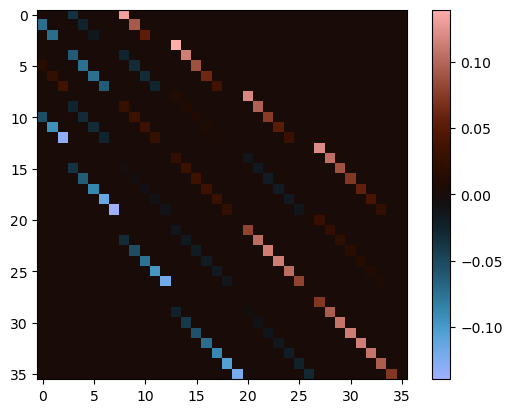

In [14]:
from matplotlib import colors as mcolors
plt.imshow(mu_q["A(v=0)"][0],cmap=scicmap.berlin,norm=mcolors.CenteredNorm())
plt.colorbar()

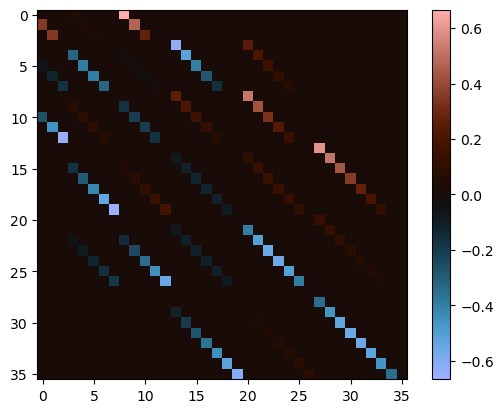

In [15]:
plt.imshow(d_q[("X(v=0)","A(v=0)")][0],cmap=scicmap.berlin,norm=mcolors.CenteredNorm())
plt.colorbar()

In [16]:
mu_q.keys()

dict_keys(['X(v=0)', 'X(v=1)', 'A(v=0)'])

In [17]:
hamiltonian = pylcp.hamiltonian(mass=46/amu_unit, k=ksim, gamma=gammasim)
[hamiltonian.add_H_0_block(l, H) for l, H in H0.items()]
[hamiltonian.add_mu_q_block(l, mu, muB=1) for l, mu in mu_q.items()]
[hamiltonian.add_d_q_block(l[0],l[1], dq, k=ksim, gamma=gammasim) for l, dq in d_q.items()]
# hamiltonian.add_d_q_block("X(v=0)","A(v=0)",dijq,k=0,gamma=gammasim*0.99)
# hamiltonian.add_d_q_block("A(v=0)","X(v=1)",dijq,k=0,gamma=gammasim*0.01)
hamiltonian.print_structure()
hamiltonian.e = hamiltonian.state_labels == "A(v=0)"

[[((<X(v=0)|H_0|X(v=0)> 36x36), (<X(v=0)|mu_q|X(v=0)> 36x36)) None
  (<X(v=0)|d_q|A(v=0)> 36x36)]
 [None ((<X(v=1)|H_0|X(v=1)> 36x36), (<X(v=1)|mu_q|X(v=1)> 36x36))
  (<X(v=1)|d_q|A(v=0)> 36x36)]
 [(<A(v=0)|d_q|X(v=0)> 36x36) (<A(v=0)|d_q|X(v=1)> 36x36)
  ((<A(v=0)|H_0|A(v=0)> 36x36), (<A(v=0)|mu_q|A(v=0)> 36x36))]]


In [18]:
mag_field = pylcp.fields.quadrupoleMagneticField(500*1e-4*cm_unit*HzperT_unit/Hz_unit)
slowing_field = pylcp.fields.magField(lambda R : np.array([R[0],R[1],-R[2]*2])*250*1e-4*cm_unit*HzperT_unit/Hz_unit if np.abs(R[0]*cm_unit)<1 else np.array([0,0,0]))
no_mag_field = pylcp.fields.constantMagneticField(np.array([0,0,0]))

In [19]:
def MOT_Beams(s, delta, wb, p):
    return {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':p[0], 'delta':delta[0], 's':s[0], 'wb':wb[0]},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim  , 'pol':p[0], 'delta':delta[0], 's':s[0], 'wb':wb[0]},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim , 'pol':p[0], 'delta':delta[0], 's':s[0], 'wb':wb[0]},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim , 'pol':p[0], 'delta':delta[0], 's':s[0], 'wb':wb[0]},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':-p[0], 'delta':delta[0], 's':s[0], 'wb':wb[0]},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':-p[0], 'delta':delta[0], 's':s[0], 'wb':wb[0]},
    ], beam_type=pylcp.gaussianBeam),
    'X(v=1)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':p[1], 'delta':delta[1], 's':s[1], 'wb':wb[1]},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim  , 'pol':p[1], 'delta':delta[1], 's':s[1], 'wb':wb[1]},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim , 'pol':p[1], 'delta':delta[1], 's':s[1], 'wb':wb[1]},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim , 'pol':p[1], 'delta':delta[1], 's':s[1], 'wb':wb[1]},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':-p[1], 'delta':delta[1], 's':s[1], 'wb':wb[1]},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':-p[1], 'delta':delta[1], 's':s[1], 'wb':wb[1]},
    ], beam_type=pylcp.gaussianBeam)}

def MOT_and_Slow_Beams(det_MOT, det_slower, repump_s, repump_delta, *args):
    return {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':1, 'wb':0.25/cm_unit},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':1, 'wb':0.25/cm_unit},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':1, 'wb':0.25/cm_unit},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':1, 'wb':0.25/cm_unit},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':+1, 'delta':det_MOT, 's':1, 'wb':0.25/cm_unit},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':+1, 'delta':det_MOT, 's':1, 'wb':0.25/cm_unit},
        {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 0, 1]), 'pol_coord':'cartesian', 'delta':det_slower, 's':1, 'wb':0.25/cm_unit}
    ], beam_type=pylcp.gaussianBeam),
    'X(v=1)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':+1, 'delta':det_MOT, 's':1, 'wb':0.25/cm_unit},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':+1, 'delta':det_MOT, 's':1, 'wb':0.25/cm_unit},
        {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 0, 1]), 'pol_coord':'cartesian', 'delta':repump_delta, 's':2, 'wb':0.25/cm_unit}
    ], beam_type=pylcp.gaussianBeam)}
    
def MOT_Beams_nov1(det_MOT, det_slower, repump_s, repump_delta, s=0.3, wb=1/cm_unit, p=1, *args):
    return {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':p, 'delta':det_MOT, 's':s, 'wb':wb},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim  , 'pol':p, 'delta':det_MOT, 's':s, 'wb':wb},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim , 'pol':p, 'delta':det_MOT, 's':s, 'wb':wb},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim , 'pol':p, 'delta':det_MOT, 's':s, 'wb':wb},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':-p, 'delta':det_MOT, 's':s, 'wb':wb},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':-p, 'delta':det_MOT, 's':s, 'wb':wb},
    ], beam_type=pylcp.gaussianBeam)}

def MOT_Beams_nov1_infinite(det_MOT, det_slower, repump_s, repump_delta, s=0.3, *args):
    return {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':s},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim  , 'pol':-1, 'delta':det_MOT, 's':s},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim , 'pol':-1, 'delta':det_MOT, 's':s},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim , 'pol':-1, 'delta':det_MOT, 's':s},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':1, 'delta':det_MOT, 's':s},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':1, 'delta':det_MOT, 's':s},
    ], beam_type=pylcp.infinitePlaneWaveBeam)}
  
def MOT_Beams_nov1_onlyx(det_MOT, *args):
    return {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1,0, 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':0.3},
        {'kvec':np.array([-1,0, 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':0.3}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}
    
def Slower(det_MOT, det_slower, repump_s, repump_delta, *args):
    return {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':1, 'delta':det_MOT, 's':0.3, 'wb':1/cm_unit},
        {'kvec':np.array([0., 1., 0.])*ksim, 'pol':np.array([1,0,0]), 'pol_coord':"cartesian", 'delta':205e6*2*np.pi/Hz_unit, 's':0.3, 'wb':10/cm_unit}
    ], beam_type=pylcp.gaussianBeam),
    'X(v=1)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':1, 'delta':repump_delta, 's':repump_s, 'wb':1/cm_unit},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':-1, 'delta':repump_delta, 's':repump_s, 'wb':1/cm_unit}
    ], beam_type=pylcp.gaussianBeam)}
    
def StefanSlower(det_MOT, det_slower, repump_s, repump_delta, *args):
    return {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([-1., 0., 0.])*ksim, 'pol':1, 'delta':det_MOT, 's':0.5, 'wb':1/cm_unit},
        {'kvec':np.array([-1., 0., 0.])*ksim, 'pol':-1, 'delta':det_MOT+205e6*2*np.pi/Hz_unit, 's':0.3, 'wb':1/cm_unit}
    ], beam_type=pylcp.gaussianBeam)#,
    #'X(v=1)->A(v=0)' : pylcp.laserBeams([
    #    {'kvec':np.array([-1., 0., 0.])*ksim, 'pol':1, 'delta':det_MOT, 's':0.5, 'wb':1/cm_unit},
    #    {'kvec':np.array([-1., 0., 0.])*ksim, 'pol':-1, 'delta':det_MOT+205e6*2*np.pi/Hz_unit, 's':0.3, 'wb':1/cm_unit}
    #], beam_type=pylcp.gaussianBeam)
    }
    
def BerlinChrp(*args):
    return {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([-1., 0., 0.])*ksim, 'pol':np.array([0,1,0]), 'delta':lambda t : (np.max([-150+50*t*t_unit/0.006,0]))*k/Hz_unit, 's': lambda t : 0 if t > 6e-3 else 2*0.100/np.pi/(0.003**2)/I_sat, 'wb':0.3/cm_unit}
    ], beam_type=pylcp.gaussianBeam)
    }
    
    
def rawBeam(det):
    return {'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0., 0.])*ksim, 'pol':+1, 'delta':det, 's':1.},
        {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':+1, 'delta':det, 's':1.}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}
def lambdaLasers(det):
    return {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0., 0.])*ksim, 'pol':+1, 'delta':det, 's':1.},
        {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':+1, 'delta':det, 's':1.}
    ], beam_type=pylcp.infinitePlaneWaveBeam),
    'X(v=1)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0., 0.])*ksim, 'pol':+1, 'delta':det, 's':1.},
        {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':+1, 'delta':det, 's':1.}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

BerlinChirp = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([-1., 0., 0.])*ksim, 'pol':np.array([0,1,0]), 'delta':lambda t : (np.max([150-50*t*t_unit/0.006,0]))*k/Hz_unit, 's': lambda t : 0 if t < 0.5e-3/t_unit else 2*0.100/np.pi/(0.003**2)/I_sat, 'wb':0.3/cm_unit}
    ], beam_type=pylcp.gaussianBeam),
    'X(v=1)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([-1., 0., 0.])*ksim, 'pol':np.array([0,1,0]), 'delta':lambda t : (np.max([150-50*(t*t_unit)/0.006,0]))*k/Hz_unit, 's': lambda t : 0 if t < 0.5e-3/t_unit else 2*0.100/np.pi/(0.003**2)/I_sat, 'wb':0.3/cm_unit}
    ], beam_type=pylcp.gaussianBeam)}

# Old trajectory sims

In [20]:
150*k/gamma

7.849293563579279

In [21]:
#print(np.diag(H0['X(v=1)']))
print(np.diag(H0['A(v=0)'])*Hz_unit/2/np.pi)

[9.06039e+07 9.06039e+07 9.06039e+07 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 2.09987e+08 2.09987e+08 2.09987e+08 2.09987e+08
 2.09987e+08 1.99498e+08 1.99498e+08 1.99498e+08 1.99498e+08 1.99498e+08
 1.99498e+08 1.99498e+08 3.61039e+08 3.61039e+08 3.61039e+08 3.61039e+08
 3.61039e+08 3.61039e+08 3.61039e+08 4.36374e+08 4.36374e+08 4.36374e+08
 4.36374e+08 4.36374e+08 4.36374e+08 4.36374e+08 4.36374e+08 4.36374e+08]


In [22]:
m_step = 10e-5/t_unit

def captured_condition(t, y):
    if sum(map(lambda x : (x*cm_unit)**2, y[-3:])) > 1e-4:
        return -1
    if sum(map(lambda x : (velocity_unit*x)**2, y[-6:-3])) > 1:
        return -1
    return 1

def weak_cap_cond(v,p):
    if sum(map(lambda x : (x*cm_unit)**2, p)) > 2e-4:
        return -1
    if sum(map(lambda x : (velocity_unit*x)**2, v)) > 1.5:
        return -1
    return 1

def lost_condition(t, y):
    return y[-3]*cm_unit- 8

def backwards_lost(t, y):
    if (y[-3]*cm_unit < -10 and y[-6]*velocity_unit < 0):
        return -1
    return 1

def isCaptured(sol):
    # captured = -1
    # finalPosition = np.array([sol.r[i][-1] for i in range(3)])
    # finalVelocity = 0*np.array([sol.v[i][-1]*velocity_unit for i in range(3)])  # Fix capture cond
    # if (np.linalg.norm(finalPosition)**2 + np.linalg.norm(finalVelocity)**2 < 1e-2):
    #     #print('initial velocity: '+ str(sol.v[0][0]) +' captured')
    #     captured = 1 
    return weak_cap_cond(sol.v[:,-1],sol.r[:,-1])
    # return captured
    
def atomTrajectoryToMOT(v0, r0, eqn, angle = 0, classifier = isCaptured, tmax=5e-2/t_unit, max_step=m_step):
    print(v0*velocity_unit)
    eqn.set_initial_pop(np.concatenate([[1./36]*36,[0]*72]))
    if (isinstance(angle, numbers.Number)):
        eqn.set_initial_position_and_velocity(r0, np.array([v0*np.cos(angle),v0*np.sin(angle),0]))
    else:
        eqn.set_initial_position_and_velocity(r0, np.array([v0*np.cos(angle[0]),v0*np.sin(angle[0])*np.cos(angle[1]),v0*np.sin(angle[0])*np.sin(angle[1])]))
    eqn.evolve_motion([0., tmax], progress_bar=True,
                      max_step = max_step,
                      rtol=1e-3, atol=np.concatenate(([1e-3]*108,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit])),method="Radau", events=[captured_condition,lost_condition,backwards_lost])

    print(classifier(eqn.sol))
    return classifier(eqn.sol)

def findCaptureVelocity(r0,eqn):
    # print('a')
    if(atomTrajectoryToMOT(2/velocity_unit, r0, eqn)==-1):
        return 0
    # print('b')
    return bisect(atomTrajectoryToMOT,2/velocity_unit, 150/velocity_unit,
       args=(r0, eqn),
       xtol=1/velocity_unit, rtol=1e-3, full_output=False)

def captureVelocityForEq(ham, lasers, mfield):
    eq = pylcp.rateeq(lasers, mfield, ham, include_mag_forces=False)
    eq.set_initial_pop(np.concatenate([[1./36]*36,[0]*72]))
    return findCaptureVelocity(np.array([-5/cm_unit,0,0]), eq)

captured_condition.terminal = True
lost_condition.terminal = True
backwards_lost.terminal = True



In [23]:
mag_field2 = pylcp.fields.quadrupoleMagneticField(1000*1e-4*cm_unit*HzperT_unit/Hz_unit)

In [77]:
P = 130
smax = 2*P/np.pi/(0.003**2)/I_sat/10000

In [78]:
I_sat

9324.387248299916

In [79]:
smax

0.09861901580583758

In [80]:
det = -1.5
R = np.linspace(-1/cm_unit, 1/cm_unit, 100)
v = np.linspace(-150/velocity_unit, 150/velocity_unit, 600)

dets = np.linspace(-4,4,360)
sols = []
for det in dets:
   print(det,end='\r')
   rateeq = pylcp.rateeq(MOT_Beams(s=[smax,smax,1],delta = [det*gammasim,0*det*gammasim,0*det*gammasim], p=[1,1,1], wb=[0.6/cm_unit,0.6/cm_unit,0.6/cm_unit]), mag_field, hamiltonian,include_mag_forces=False)
   rateeq.generate_force_profile([R,np.zeros(R.shape),np.zeros(R.shape)],
                              [np.zeros(R.shape),np.zeros(R.shape),np.zeros(R.shape)],
                           name='Frad', progress_bar=False)
   sols.append(rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
   
RR, DD = np.meshgrid(R,dets)

c:\Users\LP618\Anaconda3\lib\site-packages\pylcp-1.0.2-py3.9.egg\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part


In [82]:
Es = np.unique(np.diag(H0["A(v=0)"]*g))
# EA, UA = np.linalg.eig(H0A)
# EX, UX = np.linalg.eig(H0X)
# Es = np.unique(EA)*1e6*np.pi*2/gamma
# EsX = np.unique(EX)*1e6*np.pi*2/gamma
# Es = np.unique(np.diag(H0A))*1e6*np.pi*2/gamma
# EsX = np.unique(np.diag(H0X))*1e6*np.pi*2/gamma

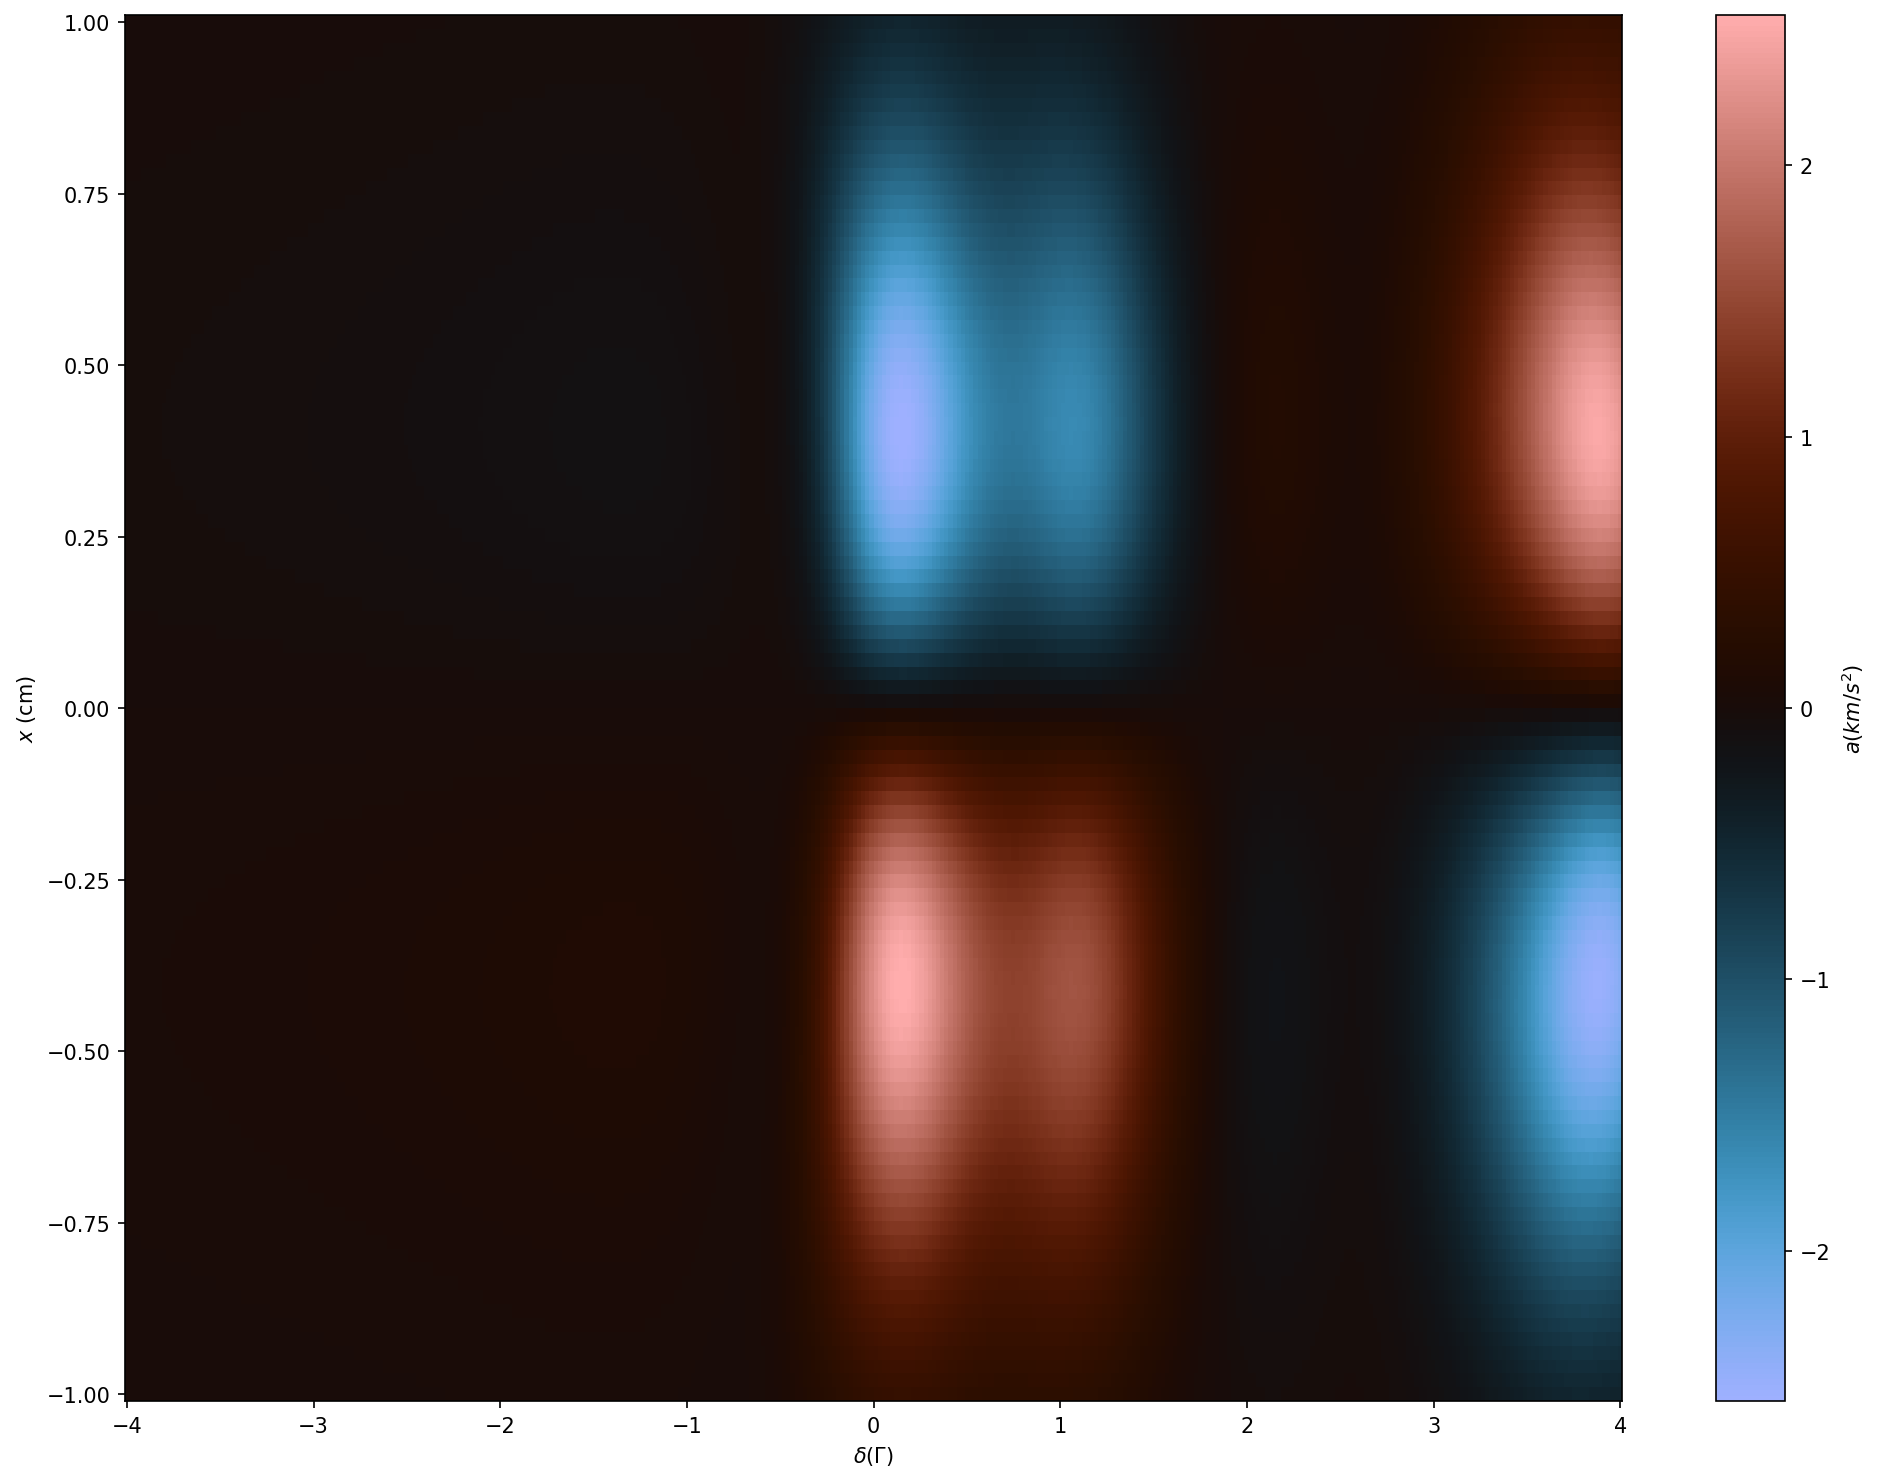

In [89]:
fig, ax = plt.subplots(1, 1,figsize=[16,12])

# colormesh = ax.plot(R*cm_unit*10, rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
colormesh = ax.pcolormesh(DD,RR*cm_unit,np.asarray(sols),cmap=scicmap.berlin,norm = mcolors.CenteredNorm(0))
cb1 = plt.colorbar(colormesh)
cb1.set_label('$a(km/s^2)$')
ax.set_ylabel('$x$ (cm)')
ax.set_xlabel('$\\delta (\\Gamma)$')
ylim = ax.get_ylim()
# ax.xlim(-20,20)
# ax.grid()
# ax.vlines(Es,-2,2,colors=['gray']*len(Es))
ax.set_ylim(ylim)
ax.vlines(Es+0.07159447,-20,20,colors=['w']*len(Es))
ax.vlines(Es-0.06259833,-20,20,colors=['g']*len(Es))
fig.subplots_adjust(left=0.12,right=0.9)

C:\Users\LP618\AppData\Local\Temp\ipykernel_8960\3246390323.py:1: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plt.plot(R*cm_unit,sols[(np.abs(dets + 1) < 1e-1)[0]])


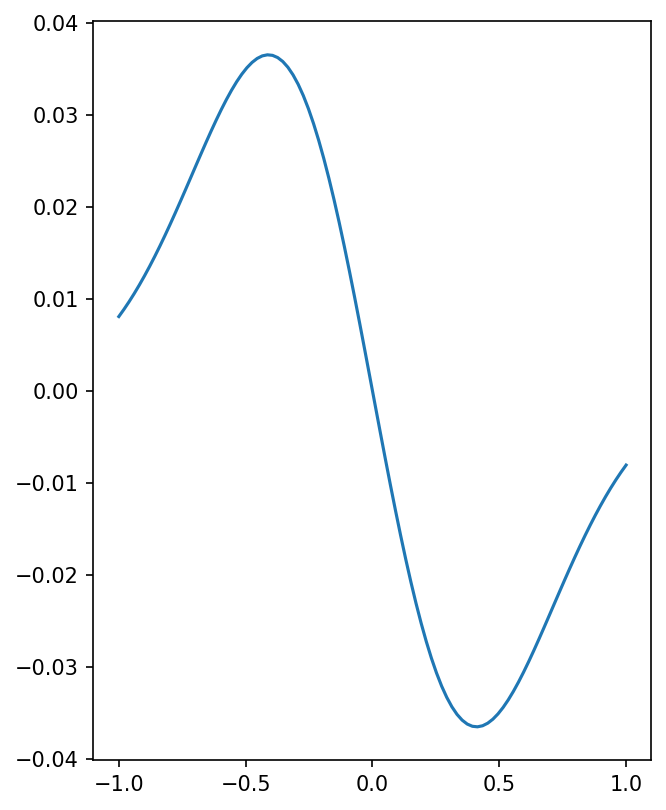

In [86]:
plt.plot(R*cm_unit,sols[(np.abs(dets + 1) < 1e-1)[0]])

In [87]:
np.argsort(np.abs(R*cm_unit))

array([49, 50, 51, 48, 52, 47, 53, 46, 45, 54, 55, 44, 56, 43, 57, 42, 58,
       41, 59, 40, 60, 39, 38, 61, 37, 62, 63, 36, 64, 35, 65, 34, 66, 33,
       67, 32, 31, 68, 69, 30, 29, 70, 28, 71, 27, 72, 73, 26, 74, 25, 24,
       75, 76, 23, 77, 22, 21, 78, 20, 79, 80, 19, 18, 81, 17, 82, 83, 16,
       84, 15, 85, 14, 86, 13, 12, 87, 88, 11, 10, 89, 90,  9, 91,  8, 92,
        7,  6, 93,  5, 94,  4, 95,  3, 96,  2, 97, 98,  1,  0, 99],
      dtype=int64)

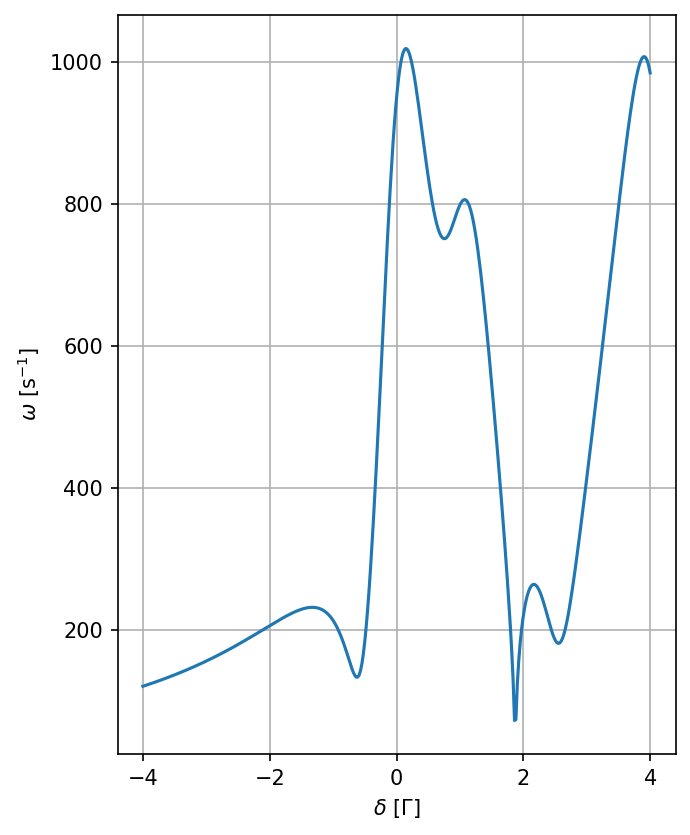

In [90]:
indx = np.argsort(np.abs(R*cm_unit))[0]
plt.plot(*(np.array([[dets[i],np.sqrt(np.abs((sols[i][indx] - sols[i][indx+1])*100_000/(R[indx + 1]*cm_unit - R[indx]*cm_unit)))] for i in range(len(dets))]).T))

# plt.vlines(Es+0.07159447,0,5000,colors=['k']*len(Es))
# plt.vlines(Es-0.06259833,0,5000,colors=['g']*len(Es))
plt.xlabel("$\\delta$ [$\\Gamma$]")
plt.ylabel("$\\omega$ [s$^{-1}$]")
plt.grid()

In [ ]:
det = -1.5
R = np.linspace(-2/cm_unit, 2/cm_unit, 160)
v = np.linspace(-150/velocity_unit, 150/velocity_unit, 600)

dets = np.linspace(-4,4,40)
sols = []
for det in dets:
   print(det,end='\r')
   rateeq = pylcp.rateeq(MOT_Beams(s=[1,1,1],delta = [det*gammasim,det*gammasim,det*gammasim], p=[1,1,1], wb=[1/cm_unit,1/cm_unit,1/cm_unit]), mag_field, hamiltonian,include_mag_forces=False)
   rateeq.generate_force_profile([R,np.zeros(R.shape),np.zeros(R.shape)],
                              [np.zeros(R.shape),np.zeros(R.shape),np.zeros(R.shape)],
                           name='Frad', progress_bar=False)
   sols.append(rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
   
RR, DD = np.meshgrid(R,dets)



In [ ]:
# Es = np.unique(np.diag(H0["A(v=0)"]*g))
Es = np.unique(H0['A(v=0)'])/gamma
# Es = np.unique(np.diag(H0A))*1e6*np.pi*2/gamma
# EsX = np.unique(np.diag(H0X))*1e6*np.pi*2/gamma

In [ ]:
EsX

array([-0.07159447, -0.07159447, -0.07159447, -0.07139511, -0.07139511,
        0.02229762,  0.02238749,  0.02238749,  0.06251043,  0.06251043,
        0.06251043,  0.06251043,  0.06259833])

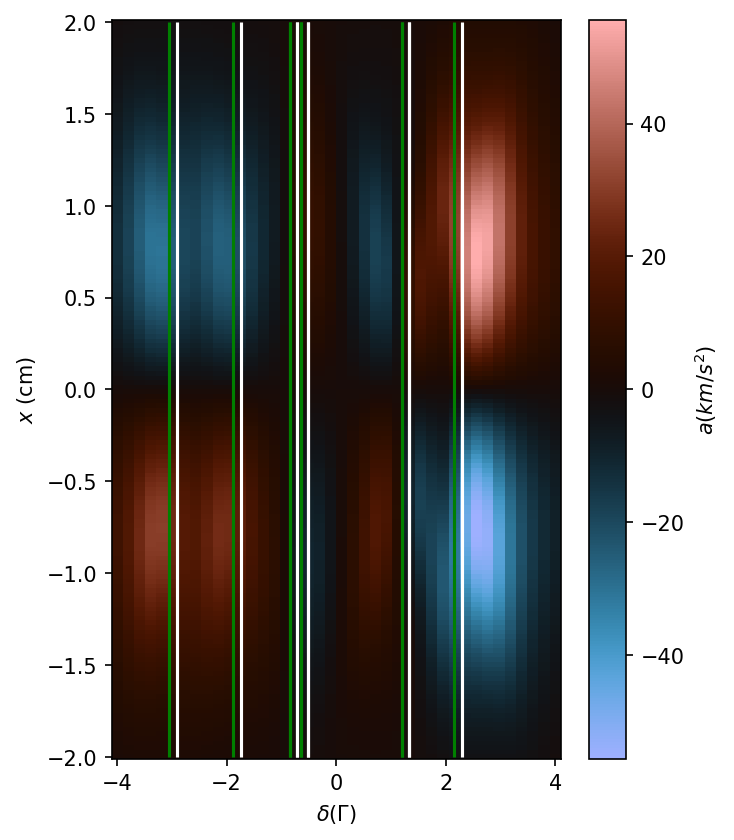

In [ ]:
fig, ax = plt.subplots(1, 1)

# colormesh = ax.plot(R*cm_unit*10, rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
colormesh = ax.pcolormesh(DD,RR*cm_unit,np.asarray(sols),cmap=scicmap.berlin,norm = mcolors.CenteredNorm(0))
cb1 = plt.colorbar(colormesh)
cb1.set_label('$a(km/s^2)$')
ax.set_ylabel('$x$ (cm)')
ax.set_xlabel('$\\delta (\\Gamma)$')
ylim = ax.get_ylim()
# ax.xlim(-20,20)
# ax.grid()
# ax.vlines(Es,-2,2,colors=['gray']*len(Es))
ax.vlines(Es+0.07159447,-2,2,colors=['w']*len(Es))
ax.vlines(Es-0.06259833,-2,2,colors=['g']*len(Es))
fig.subplots_adjust(left=0.12,right=0.9)

In [41]:
Es = np.array([9.06039e7, 0., 2.09987e8, 1.99498e8, 3.61039e8, 4.36374e8])
g = 84e6
k0 = 1/227.5e-9

Completed in 1.29 s.                                               


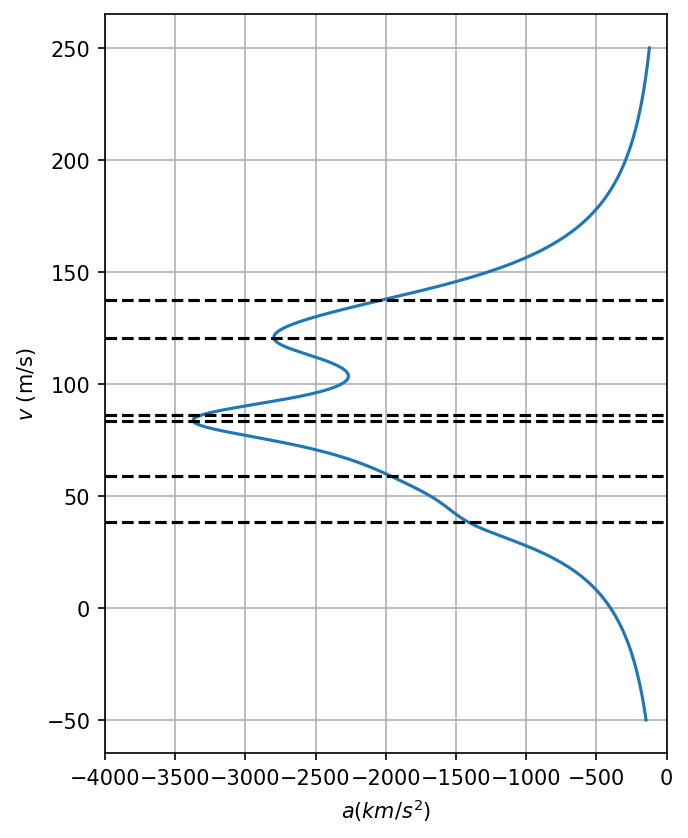

In [43]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.figsize'] = [4.8, 6.4]
mpl.rcParams['figure.dpi'] = 150

fig, ax = plt.subplots(1, 1)

for i in [0]:#,-0.5,0,0.5,1,1.5,2,2.5]:
    s = 2*0.2/(np.pi*(0.00125**2))/I_sat
    laserBeams={
        'X(v=0)->A(v=0)' : pylcp.laserBeams([
            {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':1, 'delta':-gammasim*0-2*gammasim, 's':s}
        ], beam_type=pylcp.infinitePlaneWaveBeam),
        'X(v=1)->A(v=0)' : pylcp.laserBeams([
            {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':1, 'delta':-gammasim*i-2*gammasim, 's':100000}
        ], beam_type=pylcp.infinitePlaneWaveBeam)}

    rateeq = pylcp.rateeq(laserBeams, mag_field, hamiltonian, include_mag_forces = False)
    R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
    v = np.linspace(-50/velocity_unit, 250/velocity_unit, 300) 

    rateeq.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                            [v                ,np.zeros(v.shape),np.zeros(v.shape)],
                            name='Frad', progress_bar=True)



    colormesh = ax.plot((rateeq.profile['Frad'].F[0])*F_unit*1e-3/(46*1.66e-27),v*velocity_unit)
ax.hlines((Es+2*g)/k0,-4000,0,colors=['black']*6,linestyles=['dashed']*6)

ax.set_ylabel('$v$ (m/s)')
ax.set_xlabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.set_xlim([-4000,0])
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

In [22]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.figsize'] = [4.8, 6.4]
mpl.rcParams['figure.dpi'] = 150


s = 2*0.2/(np.pi*(0.00125**2))/I_sat
laserBeams={
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':1, 'delta':-gammasim*0-2*gammasim, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam),
    'X(v=1)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([0, 1., 0.])*ksim, 'pol':1, 'delta':-gammasim*(-0*2.5)-0*gammasim, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

rateeq = pylcp.rateeq(laserBeams, mag_field, hamiltonian, include_mag_forces = False)
R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-50/velocity_unit, 250/velocity_unit, 300) 

rateeq.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                           [v                ,np.zeros(v.shape),np.zeros(v.shape)],
                           name='Frad', progress_bar=True)

Completed in 1.64 s.                                               


In [65]:
np.save("./f_profile.npy",np.array([(rateeq.profile['Frad'].F[0])*F_unit*1e-3/(46*1.66e-27),v*velocity_unit]))

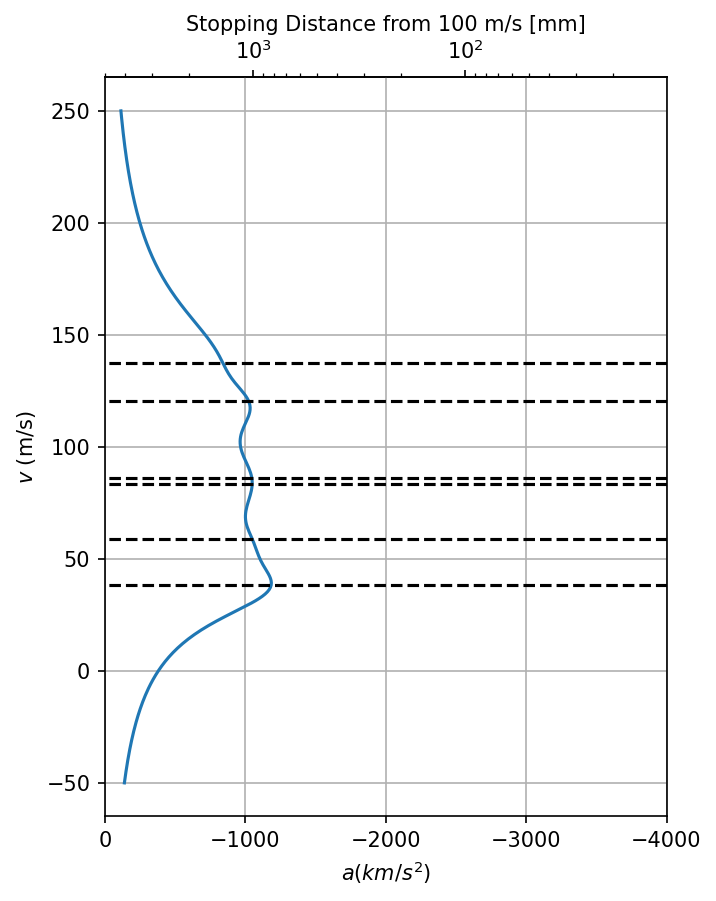

In [23]:
fig, ax = plt.subplots(1, 1)

colormesh = ax.plot((rateeq.profile['Frad'].F[0])*F_unit*1e-3/(46*1.66e-27),v*velocity_unit)
ax.hlines((Es+2*g)/k0,-4000,0,colors=['black']*6,linestyles=['dashed']*6)

def stopping_distance(x):
    x = np.array(x, float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = 100**2 / (2*x[~near_zero])
    return x

ax.set_xlim([1,-4000])
axx2 = ax.secondary_xaxis('top',functions=(stopping_distance,stopping_distance))
axx2.set_xscale('log')
axx2.set_xlabel('Stopping Distance from 100 m/s [mm]')
ax.set_ylabel('$v$ (m/s)')
ax.set_xlabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

In [121]:
captureVelocityForEq(hamiltonian, MOT_Beams_nov1(-0.5*gammasim, 0, 0, 0, s=2/6))

38.22


KeyboardInterrupt: 

c:\Users\LP618\Anaconda3\lib\site-packages\pylcp-1.0.2-py3.9.egg\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part


Completed in 0.60 s.                                               


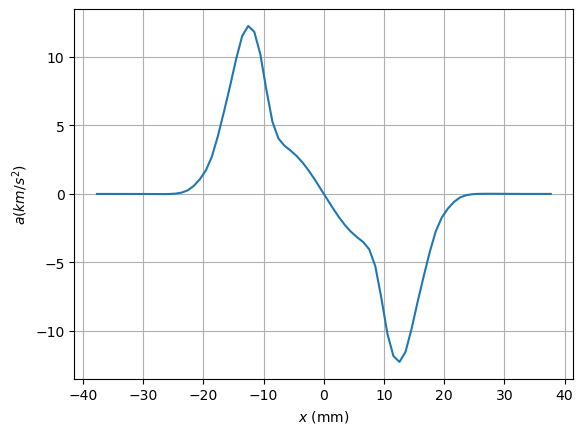

In [18]:
rateeq = pylcp.rateeq(MOT_Beams_nov1(-1.5*gammasim,0,0,0,s=0.3), mag_field, hamiltonian,include_mag_forces=False)

R = np.linspace(-10/cm_unit, 10/cm_unit, 200)
v = np.linspace(-150/velocity_unit, 150/velocity_unit, 600)

rateeq.generate_force_profile([R,np.zeros(R.shape),np.zeros(R.shape)],
                              [np.zeros(R.shape),np.zeros(R.shape),np.zeros(R.shape)],
                           name='Frad', progress_bar=True)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(R*cm_unit*10, rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$x$ (mm)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

In [62]:
def MOT_and_Slow_Beams(det_MOT, det_slower, repump_s, repump_delta, *args, **kwargs):
    s = kwargs.pop("s",repump_s)
    return {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':1, 'delta':det_MOT, 's':s/6, 'wb':0.25/cm_unit},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':1, 'delta':det_MOT, 's':s/6, 'wb':0.25/cm_unit},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':1, 'delta':det_MOT, 's':s/6, 'wb':0.25/cm_unit},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':1, 'delta':det_MOT, 's':s/6, 'wb':0.25/cm_unit},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':-1, 'delta':det_MOT, 's':s/6, 'wb':0.25/cm_unit},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':-1, 'delta':det_MOT, 's':s/6, 'wb':0.25/cm_unit},
        # {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 0, 1]), 'pol_coord':'cartesian', 'delta':det_slower, 's':lambda t : 1 if t*t_unit < 5e-3 else 0, 'wb':0.25/cm_unit}
    ], beam_type=pylcp.gaussianBeam),
    'X(v=1)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':+1, 'delta':repump_delta, 's':repump_s/6, 'wb':0.25/cm_unit},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':+1, 'delta':repump_delta, 's':repump_s/6, 'wb':0.25/cm_unit},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':repump_delta, 's':repump_s/6, 'wb':0.25/cm_unit},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':repump_delta, 's':repump_s/6, 'wb':0.25/cm_unit},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':repump_delta, 's':repump_s/6, 'wb':0.25/cm_unit},
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':repump_delta, 's':repump_s/6, 'wb':0.25/cm_unit}#,
        # {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 0, 1]), 'pol_coord':'cartesian', 'delta':repump_delta, 's':2, 'wb':0.25/cm_unit}
    ], beam_type=pylcp.gaussianBeam)}

rateeq = pylcp.rateeq(MOT_and_Slow_Beams(-1*gammasim,-100*k/Hz_unit,1,-50*k/Hz_unit), mag_field, hamiltonian,include_mag_forces=False)

In [25]:
rscat = []
ss = np.linspace(0,2000,200)
for s in ss:
    rateeq = pylcp.rateeq(MOT_and_Slow_Beams(-1*gammasim,-100*k/Hz_unit,s,-1*gammasim), mag_field, hamiltonian,include_mag_forces=False)
    rscat.append(rateeq.equilibrium_populations(np.array([0, 0, 0]),
                                               np.array([0, 0, 0]),
                                               t=10e-3/t_unit))


c:\Users\LP618\Anaconda3\lib\site-packages\pylcp-1.0.2-py3.9.egg\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part


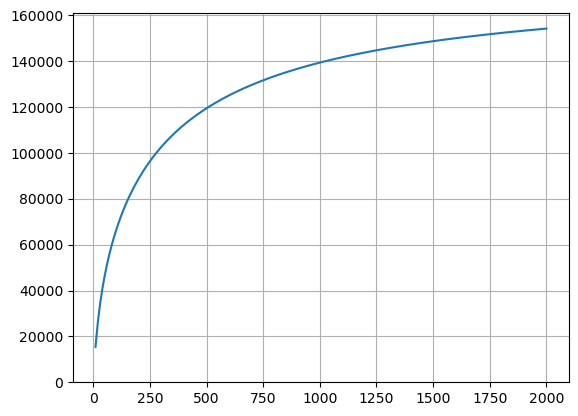

In [26]:
scat = np.array(rscat)
scat = np.sum(scat[:,-36:],axis = -1)
scat = scat*gamma/1000

plt.figure()
plt.plot(ss, scat)
plt.grid()
plt.ylim([0,plt.ylim()[1]])
plt.show()

In [48]:
from pylcp.common import progressBar
rss = np.linspace(0, 10, 50)
ss = np.linspace(0 , 10, 50)

SS, RSS = np.meshgrid(ss, rss)
rsol = []
length = SS.flatten().shape[0]
i=0
for s, rs in zip(SS.flatten(),RSS.flatten()):
    print(f"{i}/{length} {i*100/length:.2f}%",end='\r')
    i+=1
    rateeq = pylcp.rateeq(MOT_and_Slow_Beams(-1*gammasim,-100*k/Hz_unit,rs,-1*gammasim,s=s), mag_field, hamiltonian,include_mag_forces=False)
    rsol.append(rateeq.equilibrium_populations(np.array([0, 0, 0]),
                                               np.array([0, 0, 0]),
                                               t=10e-3/t_unit))

In [49]:
sol = np.array(rsol)
sol = np.sum(sol[:,-36:],axis = -1)
sol = sol.reshape(SS.shape)
sol = sol*gamma/1000

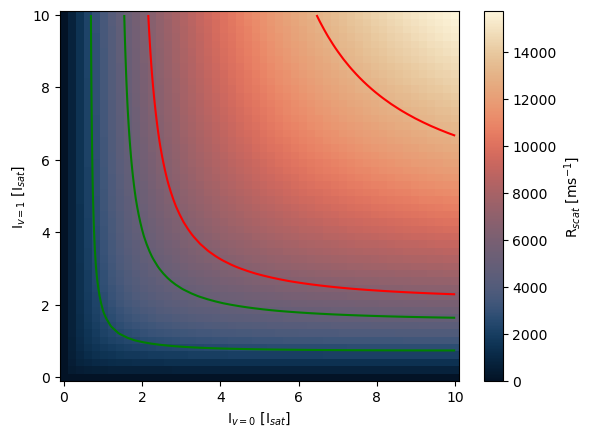

In [68]:
sol[np.isnan(sol)] = 0
fig, ax = plt.subplots(1, 1)
colormesh = ax.pcolormesh(SS, RSS, sol, cmap = scicmap.lipari)
ax.contour(SS, RSS, sol, [2500,5000,6500,13000], colors=['g','g','r','r'])
cb1 = plt.colorbar(colormesh)
cb1.set_label('R$_{scat}$ [ms$^{-1}$]')
ax.set_xlabel('I$_{v=0}$ [I$_{sat}$]')
ax.set_ylabel('I$_{v=1}$ [I$_{sat}$]')
fig.subplots_adjust(left=0.12,right=0.9)
# ax.set_xlim([-1,1])
# ax.set_ylim([-100,100])

In [63]:
from pylcp.common import progressBar
rss = np.linspace(1, 2, 4)
ss = np.linspace(1, 2, 4)

SS, RSS = np.meshgrid(ss, rss)
rsol = []
rcap = []
length = SS.flatten().shape[0]
i=0
for s, rs in zip(SS.flatten(),RSS.flatten()):
    print(f"{i}/{length} {i*100/length:.2f}%",end='\r')
    i+=1
    rateeq = pylcp.rateeq(MOT_and_Slow_Beams(-1*gammasim,-100*k/Hz_unit,rs,-1*gammasim,s=s), mag_field, hamiltonian,include_mag_forces=False)
    rsol.append(rateeq.equilibrium_populations(np.array([0, 0, 0]),
                                               np.array([0, 0, 0]),
                                               t=10e-3/t_unit))
    if s == 0 or rs == 0:
        rcap.append(0)
        continue
    rcap.append(findCaptureVelocity(np.array([-5/cm_unit,0,0]),rateeq))

2.06 0.00%
Completed in 1:17.                                                        
1
2.0
Completed in 1:18.                                                        
1
150.0
Completed in 1:52.                                                 
-1
75.99999999999999
Completed in 1:55.                                                 
-1
39.0
Completed in 1:58.                                                 
-1
20.5
Completed in 2:04.                                                 
-1
11.249999999999998
Completed in 2:19.                                                 
-1
6.624999999999999
Completed in 2:48.                                                  
-1
4.3125
Completed in 3:06.                                                  
-1
3.15625
Completed in 2:15.                                                        
1
3.7343749999999996
Completed in 3:20.                                                  
-1
2.06 6.25%
Completed in 1:30.                                                 

In [47]:
sol = rateeq.evolve_motion([0., 50e-3/t_unit], progress_bar=True,
                      max_step = 1e-4/t_unit,
                      rtol=1e-3, atol=np.concatenate(([1e-3]*108,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit])),method="Radau", events=[captured_condition,lost_condition,backwards_lost])

Completed in 1:15.                                                        


In [49]:
isCaptured(sol)

1

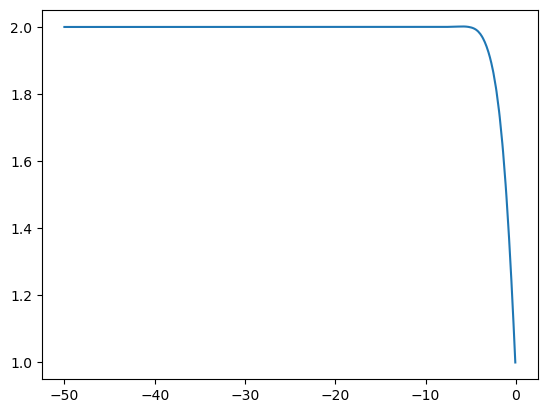

In [48]:
plt.plot(sol.r[0]*m_unit*1000,sol.v[0]*velocity_unit)

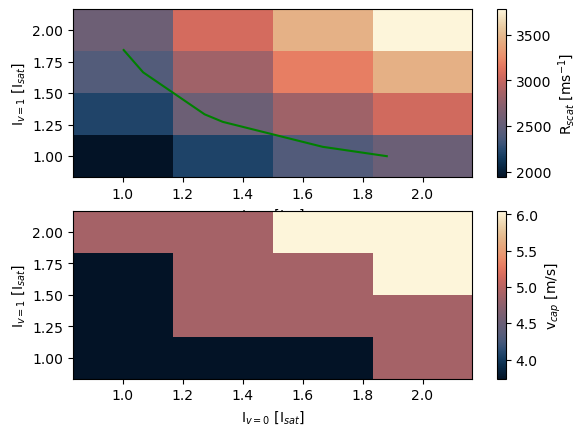

In [64]:
sol = np.array(rsol)
sol = np.sum(sol[:,-36:],axis = -1)
sol = sol.reshape(SS.shape)
sol = sol*gamma/1000

cap = np.array(rcap)
cap = cap.reshape(SS.shape)
cap = cap*velocity_unit
sol[np.isnan(sol)] = 0

fig, (ax1,ax2) = plt.subplots(2, 1)
colormesh = ax1.pcolormesh(SS, RSS, sol, cmap = scicmap.lipari)
ax1.contour(SS, RSS, sol, [2500,5000,6500,13000], colors=['g','g','r','r'])
cb1 = plt.colorbar(colormesh,ax=ax1)
cb1.set_label('R$_{scat}$ [ms$^{-1}$]')
ax1.set_xlabel('I$_{v=0}$ [I$_{sat}$]')
ax1.set_ylabel('I$_{v=1}$ [I$_{sat}$]')
colormesh2 = ax2.pcolormesh(SS, RSS, cap, cmap = scicmap.lipari)
# ax2.contour(SS, RSS, sol, [2500,5000,6500,13000], colors=['g','g','r','r'])
cb2 = plt.colorbar(colormesh2,ax=ax2)
cb2.set_label('v$_{cap}$ [m/s]')
ax2.set_xlabel('I$_{v=0}$ [I$_{sat}$]')
ax2.set_ylabel('I$_{v=1}$ [I$_{sat}$]')
fig.subplots_adjust(left=0.12,right=0.9)
# ax.set_xlim([-1,1])
# ax.set_ylim([-100,100])

In [48]:
from pylcp.common import progressBar
r = np.linspace(-1/cm_unit, 1/cm_unit, 100)
v = np.linspace(-100/velocity_unit, 100/velocity_unit, 100)

R, V = np.meshgrid(r, v)
rsol = []
length = R.flatten().shape[0]
i=0
for rr, vv in zip(R.flatten(),V.flatten()):
    print(f"{i}/{length} {i*100/length:.2f}%",end='\r')
    i+=1
    rsol.append(rateeq.equilibrium_populations(np.array([rr, 0, 0]),
                                               np.array([vv, 0, 0]),
                                               t=10e-3/t_unit))

c:\Users\LP618\Anaconda3\lib\site-packages\pylcp-1.0.2-py3.9.egg\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part


In [49]:
sol = np.array(rsol)
sol = np.sum(sol[:,-36:],axis = -1)
sol = sol.reshape(R.shape)
sol = sol*gamma/1000

(-100.0, 100.0)

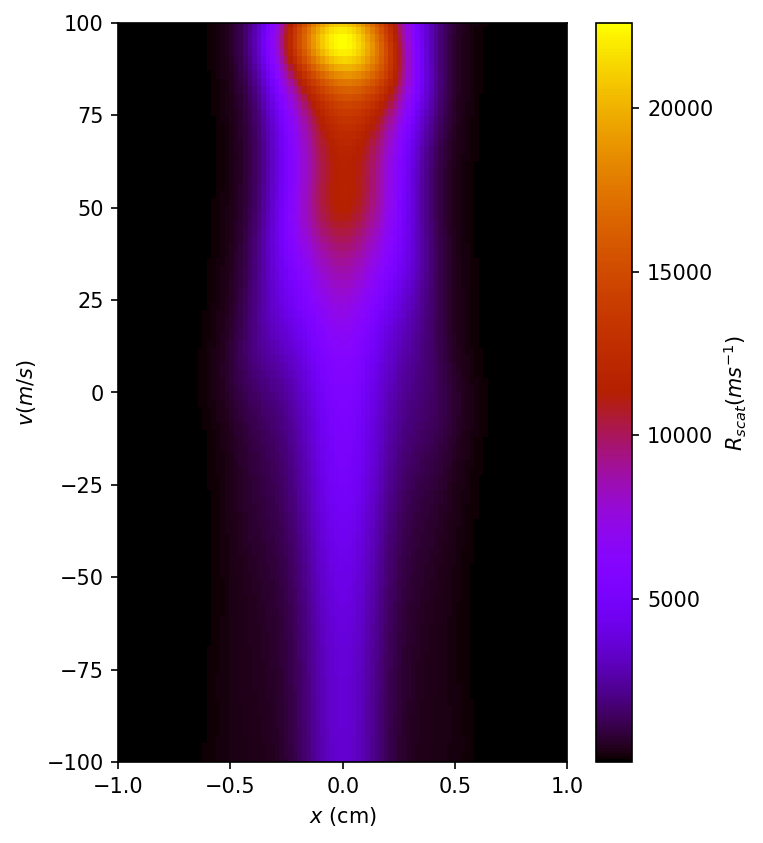

In [51]:
sol[np.isnan(sol)] = 0
fig, ax = plt.subplots(1, 1)
colormesh = ax.pcolormesh(R*cm_unit, V*velocity_unit, sol, cmap = 'gnuplot')
cb1 = plt.colorbar(colormesh)
cb1.set_label('$R_{scat} (ms^{-1})$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v(m/s)$')
fig.subplots_adjust(left=0.12,right=0.9)
ax.set_xlim([-1,1])
ax.set_ylim([-100,100])

In [27]:
def MOT_and_Slow_Beams(det_MOT, det_slower, repump_s, repump_delta, *args):
    return {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':2, 'wb':0.25/cm_unit},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':2, 'wb':0.25/cm_unit},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':2, 'wb':0.25/cm_unit},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':2, 'wb':0.25/cm_unit},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':+1, 'delta':det_MOT, 's':2, 'wb':0.25/cm_unit},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':+1, 'delta':det_MOT, 's':2, 'wb':0.25/cm_unit},
        {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 0, 1]), 'pol_coord':'cartesian', 'delta':det_slower, 's':lambda t : 1 if t*t_unit < 5e-3 else 0, 'wb':0.25/cm_unit}
    ], beam_type=pylcp.gaussianBeam),
    'X(v=1)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':-1, 'delta':repump_delta, 's':2, 'wb':0.25/cm_unit},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':-1, 'delta':repump_delta, 's':2, 'wb':0.25/cm_unit},
        {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 0, 1]), 'pol_coord':'cartesian', 'delta':repump_delta, 's':2, 'wb':0.25/cm_unit}
    ], beam_type=pylcp.gaussianBeam)}

rateeq = pylcp.rateeq(MOT_and_Slow_Beams(-1*gammasim,-100*k/Hz_unit,0,-50*k/Hz_unit), slowing_field, hamiltonian,include_mag_forces=False)

In [32]:
r = np.linspace(-82/cm_unit, 2/cm_unit, 840)
v = np.linspace(-100/velocity_unit, 200/velocity_unit, 50)

R, V = np.meshgrid(r, v)
rateeq.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True)

Completed in 2:29.                                                  


In [28]:
angle = float(0)
vel = float(30)

vs = np.linspace(100,200,11)
# vs = [150]
sols = []
for vel in vs:
    rateeq.set_initial_position_and_velocity(np.array([-80/cm_unit, 0./cm_unit, 0.]),np.array([vel*np.cos(np.radians(angle))/velocity_unit, vel*np.sin(np.radians(angle))/velocity_unit, 0.]))
    rateeq.set_initial_pop(np.concatenate(([1./36]*36,[0]*72)))
    rateeq.evolve_motion([0., 100e-3/t_unit], progress_bar=True, max_step = 1e-4/t_unit, rtol=1e-3, atol=np.concatenate(([1e-3]*108,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit])),method="Radau", events=[captured_condition,lost_condition,backwards_lost])
    sols.append(rateeq.sol)


Completed in 20.63 s.                                                
Completed in 21.30 s.                                               
Completed in 23.47 s.                                               
Completed in 24.46 s.                                               
Completed in 1:45.                                                   
Completed in 1:47.                                                  
Completed in 1:57.                                                  
Completed in 1:52.                                                  
Completed in 1:55.                                                   
Completed in 2:00.                                                   
Completed in 2:22.                                                   


(-100.0, 200.0)

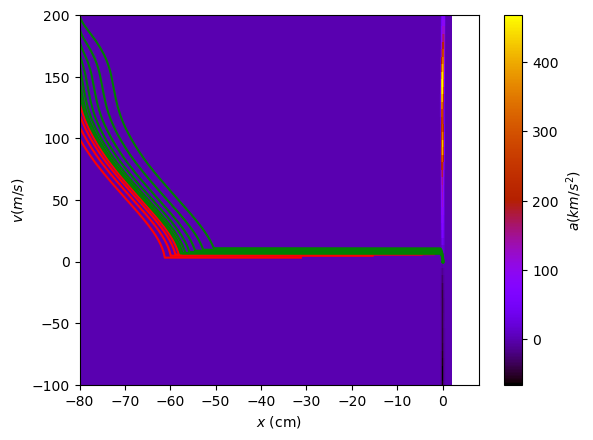

In [34]:
Fprofile = rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27)
Fprofile[np.isnan(Fprofile)] = 0
fig, ax = plt.subplots(1, 1)
[ax.plot(sol.r[0]*cm_unit,sol.v[0]*velocity_unit,'g-' if isCaptured(sol) > 0 else 'r-') for sol in sols]
colormesh = ax.pcolormesh(R*cm_unit, V*velocity_unit, -Fprofile, cmap = 'gnuplot')
cb1 = plt.colorbar(colormesh)
cb1.set_label('$a(km/s^2)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v(m/s)$')
fig.subplots_adjust(left=0.12,right=0.9)
ax.set_xlim([-80,8])
ax.set_ylim([-100,200])

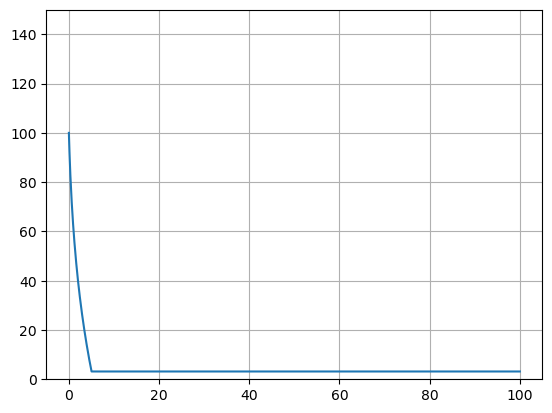

In [35]:
plt.plot(sols[0].t*t_unit*1000,sols[0].v[0]*velocity_unit)
plt.ylim([0,150])
plt.grid()

In [30]:
def MOT_and_Slow_Beams(det_MOT, det_slower, repump_s, repump_delta, *args):
    return {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':2, 'wb':0.25/cm_unit},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':2, 'wb':0.25/cm_unit},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':2, 'wb':0.25/cm_unit},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.])*ksim, 'pol':-1, 'delta':det_MOT, 's':2, 'wb':0.25/cm_unit},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':+1, 'delta':det_MOT, 's':2, 'wb':0.25/cm_unit},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':+1, 'delta':det_MOT, 's':2, 'wb':0.25/cm_unit}
    ], beam_type=pylcp.gaussianBeam),
    'X(v=1)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':-1, 'delta':repump_delta, 's':2, 'wb':0.25/cm_unit},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':-1, 'delta':repump_delta, 's':2, 'wb':0.25/cm_unit},
        {'kvec':np.array([-1, 0., 0.])*ksim, 'pol':np.array([0, 0, 1]), 'pol_coord':'cartesian', 'delta':repump_delta, 's':2, 'wb':0.25/cm_unit}
    ], beam_type=pylcp.gaussianBeam)}

rateeq = pylcp.rateeq(MOT_and_Slow_Beams(-1*gammasim,-100*k/Hz_unit,0,-50*k/Hz_unit), slowing_field, hamiltonian,include_mag_forces=False)

In [57]:
np.array([[11,12,13,14],[21,22,23,24],[31,32,33,34],[41,42,43,44]])[[3,0,1,2]][:,[2,3,0,1]]

array([[43, 44, 41, 42],
       [13, 14, 11, 12],
       [23, 24, 21, 22],
       [33, 34, 31, 32]])

In [47]:
[isCaptured(sol)>0 for sol in sols]

[True, True, True, True, False, False, False, False, False, False]

In [37]:
rateeq = pylcp.rateeq(MOT_Beams_nov1(-1*gammasim,0,0,0,s=0.16, wb=0.5/cm_unit, p=1), mag_field, hamiltonian,include_mag_forces=False)
rateeq.set_initial_pop(np.concatenate([[1/36]*36,[0]*36]))
rateeq.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))

obe = pylcp.obe(MOT_Beams_nov1(-1*gammasim,0,0,0,s=0.16, wb=0.5/cm_unit, p=1), mag_field, hamiltonian,include_mag_forces=False)


TypeError: 'list' object cannot be interpreted as an integer

In [65]:
obe.set_initial_rho_from_populations(np.concatenate([[1/36]*36,[0]*36]))
obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
e_state_pops = lambda s, rateeq, obe : [s, np.sum(rateeq.sol.y[36:,-1]), np.sum(np.diag(obe.sol.rho[:,:,-1])[36:])]

e_pop = []
for s in np.linspace(0.01,1,10):
    rateeq = pylcp.rateeq(MOT_Beams_nov1(0*gammasim,0,0,0,s=s, wb=0.5/cm_unit, p=1), mag_field, hamiltonian,include_mag_forces=False)
    rateeq.set_initial_pop(np.concatenate([[1/36]*36,[0]*36]))
    rateeq.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
    obe.laserBeams = MOT_Beams_nov1(0*gammasim,0,0,0,s=s, wb=0.5/cm_unit, p=1)
    
    obe.evolve_density([0,200/gammasim],
                    rtol=1e-6,
                    atol=np.concatenate(([1e-6]*72*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="RK23",
                    progress_bar=True);
    
    rateeq.evolve_populations([0,200/gammasim], progress_bar=True, method="RK23", rtol=1e-6)
    e_pop.append(e_state_pops(s,rateeq,obe))

e_pop = np.array(e_pop)    

Completed in 1.15 s.                                               
Completed in 1.02 s.                                               
Completed in 1.19 s.                                               
Completed in 1.07 s.                                               
Completed in 1.09 s.                                               
Completed in 1.16 s.                                               
Completed in 1.19 s.                                               
Completed in 1.18 s.                                               
Completed in 1.12 s.                                               
Completed in 1.09 s.                                               


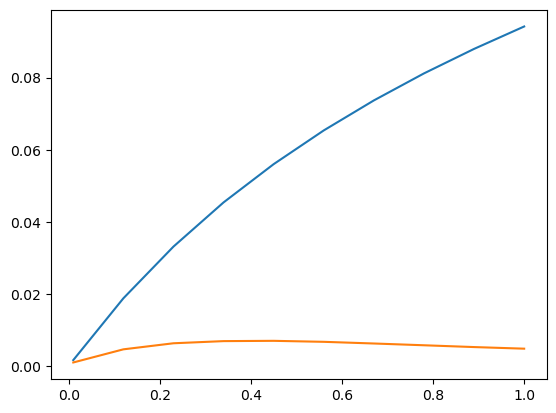

In [66]:
plt.plot(e_pop[:,0],e_pop[:,1])
plt.plot(e_pop[:,0],e_pop[:,2])

In [20]:
rateeq = pylcp.rateeq(MOT_and_Slow_Beams(-2*np.pi*43e6/Hz_unit,0,1,2*np.pi*205e6/Hz_unit), mag_field, hamiltonian,include_mag_forces=False)

R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-300/velocity_unit, 300/velocity_unit, 600)

rateeq.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                              [v,np.zeros(v.shape),np.zeros(v.shape)],
                           name='Frad', progress_bar=True)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(v*velocity_unit, rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

ValueError: laserBeams dictionary keys X(v=1)->A(v=0) does not have a corresponding key the Hamiltonian d_q.

In [38]:
10000*2/I_sat

2.1449130615683654

c:\Users\LP618\Anaconda3\lib\site-packages\pylcp-1.0.2-py3.9.egg\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part


Completed in 1.54 s.                                               


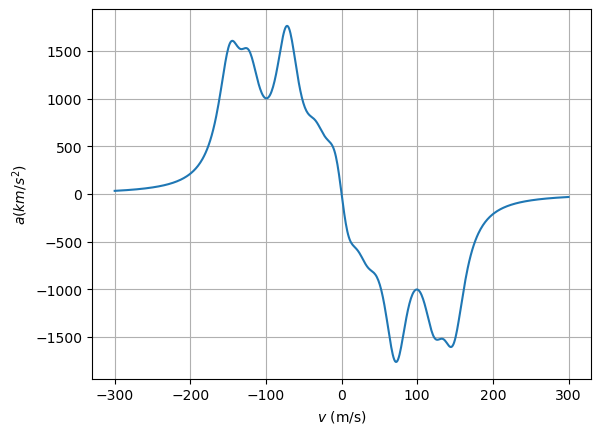

In [39]:
rateeq = pylcp.rateeq(MOT_Beams_nov1(-0.3*gammasim,0,1,2*np.pi*205e6/Hz_unit, s=2.14), mag_field, hamiltonian,include_mag_forces=False)

R = np.linspace(-10/cm_unit, 10.000/cm_unit, 100)
v = np.linspace(-300/velocity_unit, 300/velocity_unit, 600)

rateeq.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                              [v,np.zeros(v.shape),np.zeros(v.shape)],
                           name='Frad', progress_bar=True)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(v*velocity_unit, rateeq.profile['Frad'].F[0]*accel_unit*1e-3/(46/amu_unit))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

# OBEs

In [39]:
obe_kwargs = dict(itermax=10, rel=1e-6, abs=(1000*(46*1.66e-27)/(F_unit))**2, #deltat_func = lambda r, v : 1/gammasim+0*(1/gammasim if ksim/abs(v[0]) < 1/gammasim else 2*np.pi/ksim/abs(v[0])), deltat_r=np.inf,
                  deltat_tmax = 500/gammasim, deltat_v=250/ksim,
                  Npts=25001, debug = False, rtol=1e-4, reset_pos = False,
                  atol=np.concatenate(([1e-4]*72*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])))

## Force curves

Completed in 1.00 s.                                               


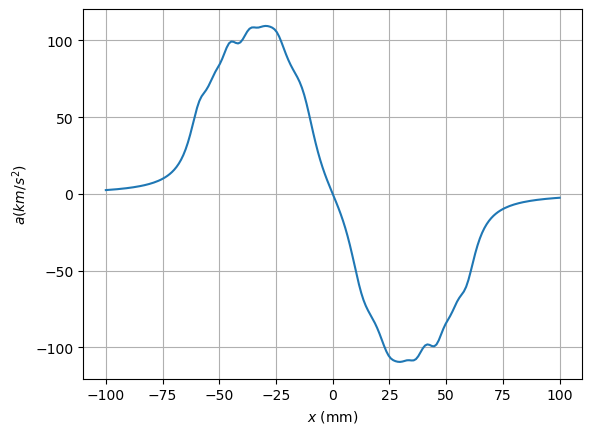

In [64]:
rateeq = pylcp.rateeq(MOT_Beams_nov1(-1*gamma/Hz_unit,0,1,2*np.pi*205e6/Hz_unit), mag_field, hamiltonian,include_mag_forces=False)

R = np.linspace(-10/cm_unit, 10/cm_unit, 200)
v = np.linspace(-150/velocity_unit, 150/velocity_unit, 600)

rateeq.generate_force_profile([R,np.zeros(R.shape),np.zeros(R.shape)],
                              [np.zeros(R.shape),np.zeros(R.shape),np.zeros(R.shape)],
                           name='Frad', progress_bar=True)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(R*cm_unit*10, rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$x$ (mm)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

In [41]:
obe = pylcp.obe(MOT_Beams_nov1(-1*gamma/Hz_unit,0,1,2*np.pi*205e6/Hz_unit), mag_field, hamiltonian,include_mag_forces=False, transform_into_re_im=False)

In [19]:
obe.laserBeams=MOT_Beams_nov1_infinite(-1*gamma/Hz_unit,0,1,2*np.pi*205e6/Hz_unit,s=0.3)

In [42]:
import dill
with open("AlF_v0_-1.dump", 'wb') as file:
    dill.dump(obe,file)

In [43]:
obe_nomag = pylcp.obe(MOT_Beams_nov1(-1*gamma/Hz_unit,0,1,2*np.pi*205e6/Hz_unit), no_mag_field, hamiltonian,include_mag_forces=False, transform_into_re_im=False)

In [44]:
import dill
with open("AlF_v0_-1_nomag.dump", 'wb') as file:
    dill.dump(obe_nomag,file)

In [ ]:
import dill
with open("AlF_v0_-1.dump", 'rb') as file:
    obe = dill.load(file)

In [22]:
import sympy

In [16]:
obe = pylcp.obe(MOT_Beams_nov1_onlyx(2*np.pi*(1.6*84e6)/Hz_unit,0,1,2*np.pi*205e6/Hz_unit), mag_field, hamiltonian,include_mag_forces=False, transform_into_re_im=False)

In [ ]:
import dill
with open("AlF_v0_1.6.dump", 'wb') as file:
    dill.dump(obe,file)

In [64]:
import dill
with open("AlF_v0_1.6.dump", 'rb') as file:
    obe = dill.load(file)

In [20]:
import sys

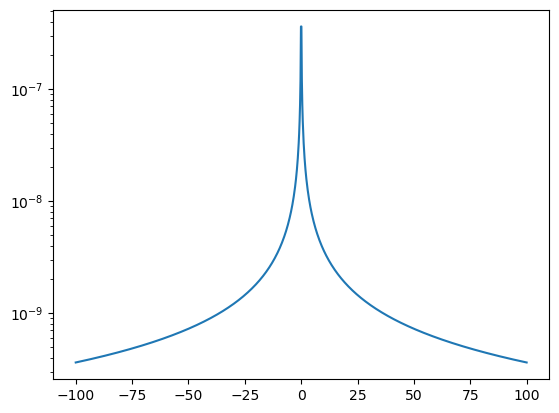

In [35]:
xs = np.linspace(-100, 100, 1000)
plt.plot(xs, [((0.1/gamma if k/np.abs(v) < 0.1/gamma else 1/k/np.abs(v))) for v in xs])
plt.yscale('log')

In [27]:
obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
obe.set_initial_rho_from_rateeq()

c:\Users\LP618\Anaconda3\lib\site-packages\pylcp-1.0.2-py3.9.egg\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part
  self.Rijl[key][ll] = gamma*intensity/2*\


In [ ]:
R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-150/velocity_unit, 150/velocity_unit, 300) 

obe.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                           [v/np.sqrt(2),     v/np.sqrt(2),     np.zeros(v.shape)],
                           name='Frad', progress_bar=True, **obe_kwargs)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(v*velocity_unit, (obe.profile['Frad'].F[0])*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

Completed in 13:45:15.                                              


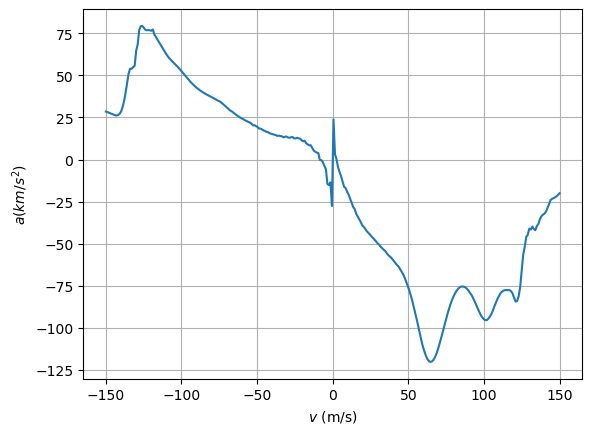

In [22]:
R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-150/velocity_unit, 150/velocity_unit, 300) 

obe.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                           [v/np.sqrt(2),     v/np.sqrt(2),     np.zeros(v.shape)],
                           name='Frad', progress_bar=True, **obe_kwargs)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(v*velocity_unit, (obe.profile['Frad'].F[0])*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

Completed in 12:44:26.                                               


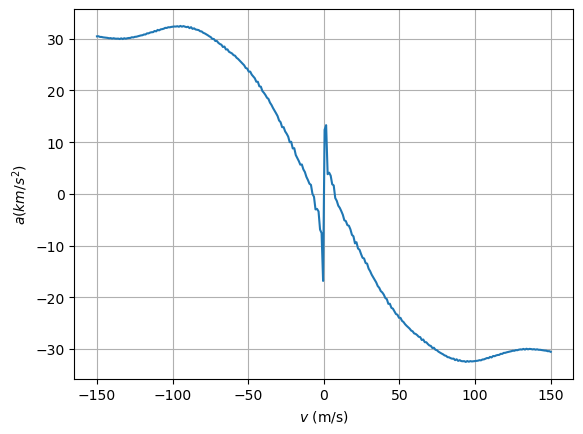

In [21]:
R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-150/velocity_unit, 150/velocity_unit, 300) 

obe.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                           [v/np.sqrt(2),     v/np.sqrt(2),     np.zeros(v.shape)],
                           name='Frad', progress_bar=True, **obe_kwargs)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(v*velocity_unit, obe.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

Completed in 0.64 s.                                               


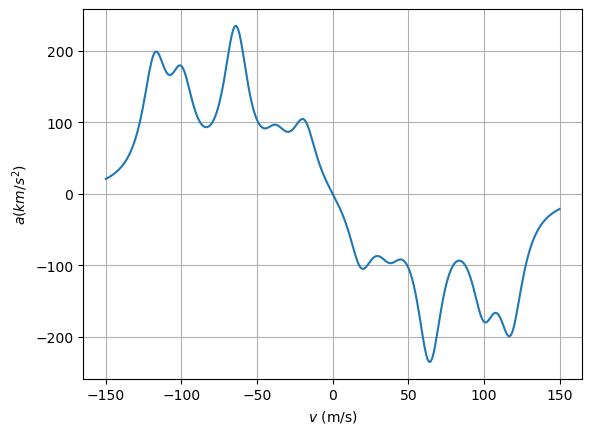

In [46]:
rateeq = pylcp.rateeq(MOT_Beams_nov1_infinite(-1*gamma/Hz_unit,0,1,2*np.pi*205e6/Hz_unit,s=0.3), no_mag_field, hamiltonian,include_mag_forces=False)
R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-150/velocity_unit, 150/velocity_unit, 300) 

rateeq.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                           [v/np.sqrt(2),     v/np.sqrt(2),     np.zeros(v.shape)],
                           name='Frad', progress_bar=True)


fig, ax = plt.subplots(1, 1)
colormesh = ax.plot(v*velocity_unit, (rateeq.profile['Frad'].F[0])*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

c:\Users\LP618\Anaconda3\lib\site-packages\pylcp-1.0.2-py3.9.egg\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part


c:\Users\LP618\Anaconda3\lib\site-packages\pylcp-1.0.2-py3.9.egg\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part


Completed in 21:26:28.                                               


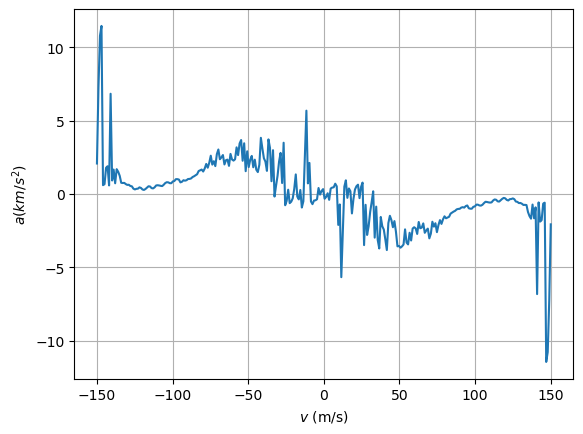

In [19]:
R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-150/velocity_unit, 150/velocity_unit, 300) 

obe.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                           [v,                np.zeros(v.shape),np.zeros(v.shape)],
                           name='Frad', progress_bar=True, **obe_kwargs)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(v*velocity_unit, obe.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

Completed in 27:37:10.                                               


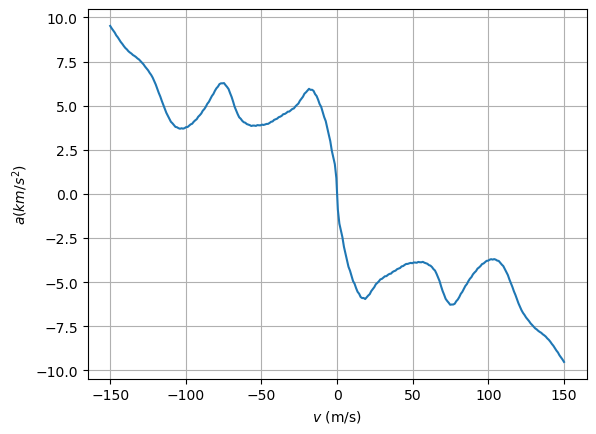

In [21]:
R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-150/velocity_unit, 150/velocity_unit, 300) 

obe.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                           [v,                np.zeros(v.shape),np.zeros(v.shape)],
                           name='Frad', progress_bar=True, **obe_kwargs)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(v*velocity_unit, obe.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

c:\Users\LP618\Anaconda3\lib\site-packages\pylcp-1.0.2-py3.9.egg\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part


c:\Users\LP618\Anaconda3\lib\site-packages\pylcp-1.0.2-py3.9.egg\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part


Completed in 5:12:52.                                               


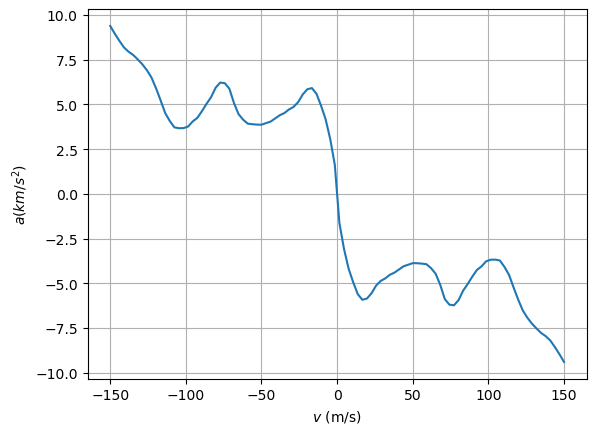

In [18]:
R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-150/velocity_unit, 150/velocity_unit, 300) 

obe.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                           [v,                np.zeros(v.shape),np.zeros(v.shape)],
                           name='Frad', progress_bar=True, **obe_kwargs)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(v*velocity_unit, obe.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

In [22]:
obe = pylcp.obe(MOT_Beams_nov1((-0.5)*gamma/Hz_unit,0,1,2*np.pi*205e6/Hz_unit), mag_field, hamiltonian,include_mag_forces=False, transform_into_re_im=False)

In [28]:
obe = pylcp.obe(MOT_Beams_nov1_onlyx((-0.5)*gamma/Hz_unit), mag_field, hamiltonian,include_mag_forces=False, transform_into_re_im=False)

In [40]:
obe = pylcp.obe(MOT_Beams_nov1_onlyx(-2*np.pi*43e6/Hz_unit), no_mag_field, hamiltonian,include_mag_forces=False, transform_into_re_im=False)

In [19]:
import dill
with open("AlF_v0_-0.5.dump", 'wb') as file:
    dill.dump(obe,file)

In [ ]:
import dill
with open("AlF_v0_-0.5.dump", 'rb') as file:
    obe = dill.load(file)

Completed in 4:38:41.                                               


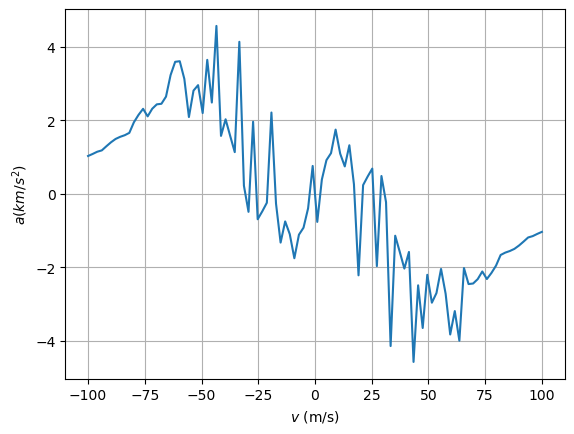

In [32]:
R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-100/velocity_unit, 100/velocity_unit, 100)

obe.generate_force_profile([np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
                           [v,                 np.zeros(v.shape), np.zeros(v.shape)],
                           name='Frad', progress_bar=True, **obe_kwargs)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(v*velocity_unit, obe.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

In [346]:
gammasim

1.0000000000000002

In [21]:
R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-50/velocity_unit, 50/velocity_unit, 100)

obe.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                              [v,np.zeros(v.shape),np.zeros(v.shape)],
                           name='Frad2', progress_bar=True, itermax=10, rel=1e-4, abs=(1/accel_unit)*(46/amu_unit),deltat_tmax=20/gammasim, deltat=20/gammasim, debug=False, Npts=2001)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(v*velocity_unit, obe.profile['Frad2'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

c:\Users\LP618\Anaconda3\lib\site-packages\pylcp-1.0.2-py3.9.egg\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part


## OBE evolution

In [21]:
det = 2*np.pi*(2)*84e6/Hz_unit
s = 1
beams = {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':np.array([0,1,1])/np.sqrt(2), 'pol_coord': 'cartesian', 'delta':det, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

obe = pylcp.obe(beams, no_mag_field, hamiltonian,include_mag_forces=False, transform_into_re_im=False)

In [17]:
obe.laserBeams['X(v=0)->A(v=0)']

In [22]:
obe.set_initial_position_and_velocity(np.array([0,0,0]),np.array([0,0,0]))
obe.set_initial_rho_from_populations(np.concatenate(([1],[0]*35,[0]*36)))

In [25]:
obe.evolve_density([0,1000/gammasim],
                    rtol=1e-9,
                    atol=np.concatenate(([1e-9]*72*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                    method="DOP853",
                    progress_bar=True);

Completed in 32.38 s.                                               


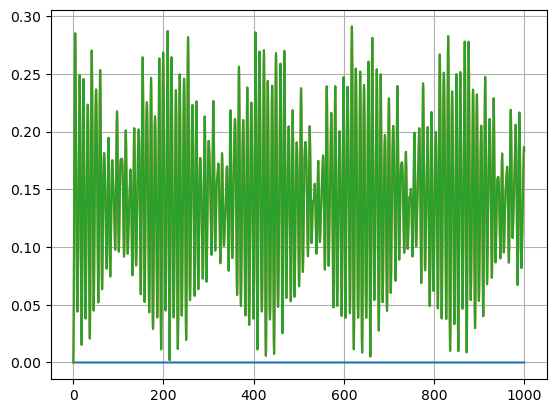

In [26]:
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho),axis=1), label="total")
plt.plot(obe.sol.t, 1-np.sum(np.diagonal(obe.sol.rho)[:,0:36],axis=1), label="g")
plt.plot(obe.sol.t, np.sum(np.diagonal(obe.sol.rho)[:,36:-1],axis=1), label="e")
# plt.yscale('log')
#plt.xlim([2*np.pi*2000/gammasim*0.99,2*np.pi*2000/gammasim])
plt.grid()

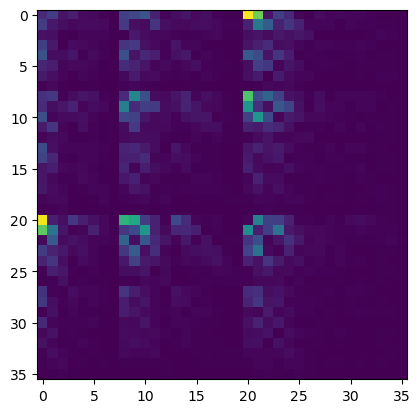

In [140]:
driving = np.einsum("ijk,i,kl->jl", dijq, np.array([1,0,1]),obe.sol.rho[:36,:36,-1])-np.einsum("ijk,i,lj->lk", dijq, np.array([1,0,1]),obe.sol.rho[:36,:36,-1])
plt.imshow(np.abs(driving))

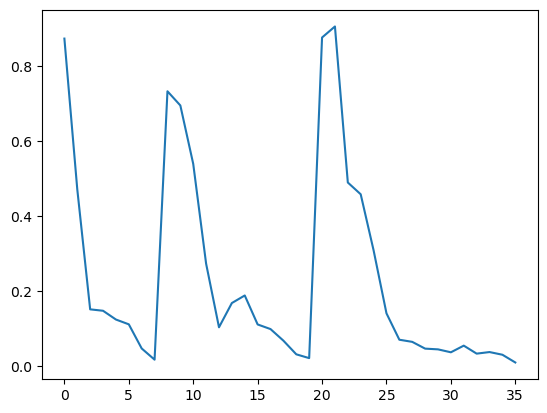

In [143]:
plt.plot(np.sum(np.abs(driving),axis=0))

In [151]:
eigen = np.linalg.eig(np.einsum("ijk,i->jk",dijq,np.array([1,0,1])))

In [154]:
np.abs(eigen[0][np.abs(eigen[0])<1e-3])

array([0.00055525, 0.00055525, 0.00047606, 0.00047606])

In [153]:
np.abs(eigen[1][np.abs(eigen[0])<1e-3])

array([[1.67754751e-02, 1.67754751e-02, 3.04403406e-03, 3.04403406e-03,
        1.67754751e-02, 1.67754751e-02, 1.26988141e-01, 1.26988141e-01,
        3.05313653e-01, 3.05313653e-01, 2.53015614e-01, 2.53015614e-01,
        8.80601712e-02, 8.80601712e-02, 4.42596089e-02, 4.42596089e-02,
        8.80601712e-02, 8.80601712e-02, 4.42596089e-02, 4.42596089e-02,
        2.32923733e-01, 2.32923733e-01, 2.60694058e-15, 2.60694058e-15,
        5.74146410e-02, 5.74146410e-02, 3.43711707e-01, 3.43711707e-01,
        1.57670160e-01, 1.57670160e-01, 4.53603231e-02, 4.53603231e-02,
        1.76664908e-01, 1.76664908e-01, 1.61815069e-02, 1.61815069e-02],
       [2.81992590e-01, 2.81992590e-01, 3.17138191e-01, 3.17138191e-01,
        2.81992590e-01, 2.81992590e-01, 8.24848900e-03, 8.24848900e-03,
        3.34203303e-02, 3.34203303e-02, 2.06281022e-02, 2.06281022e-02,
        1.08398219e-01, 1.08398219e-01, 1.94972870e-01, 1.94972870e-01,
        1.08398219e-01, 1.08398219e-01, 1.94972870e-01, 1.94972

In [113]:
[print(i, j*36) for i, j in zip(full_labels, np.abs(np.diagonal(obe.sol.rho[:,:,-1])))];

[ 1.5  1.  -1. ] 6.897747601359116
[1.5 1.  0. ] 1.9495824593008662
[1.5 1.  1. ] 0.6135627416370482
[ 1.5  2.  -2. ] 0.13690206690185353
[ 1.5  2.  -1. ] 0.20185121219703944
[1.5 2.  0. ] 0.19836717343384044
[1.5 2.  1. ] 0.12984483420558404
[1.5 2.  2. ] 0.059789437135943944
[ 2.5  2.  -2. ] 1.1504961490164058
[ 2.5  2.  -1. ] 2.7379168852691937
[2.5 2.  0. ] 1.6106123554718927
[2.5 2.  1. ] 1.2269227243511058
[2.5 2.  2. ] 0.4539381453135891
[ 2.5  3.  -3. ] 0.5233890517648646
[ 2.5  3.  -2. ] 0.20111192107757017
[ 2.5  3.  -1. ] 0.10849815531313675
[2.5 3.  0. ] 0.08693415263594671
[2.5 3.  1. ] 0.07292140306143179
[2.5 3.  2. ] 0.049948332092417905
[2.5 3.  3. ] 0.02890046262760025
[ 3.5  3.  -3. ] 9.219249420182658
[ 3.5  3.  -2. ] 2.2758069885980996
[ 3.5  3.  -1. ] 1.9487668893216934
[3.5 3.  0. ] 1.2250880944991231
[3.5 3.  1. ] 0.814295889904436
[3.5 3.  2. ] 0.8554887883570682
[3.5 3.  3. ] 0.7038666496021168
[ 3.5  4.  -4. ] 0.08429675363650856
[ 3.5  4.  -3. ] 0.0637858776

KeyboardInterrupt: 

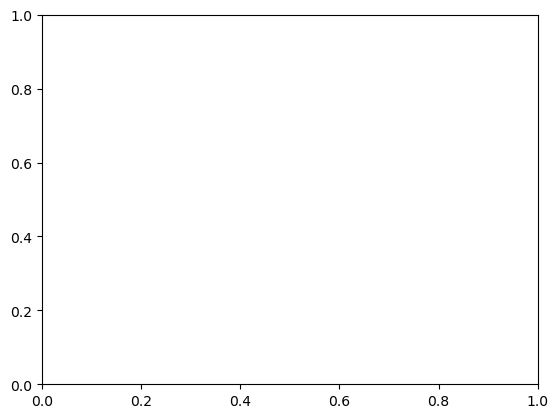

In [359]:
from pylcp.common import progressBar
eqn = obe
#eqn = pylcp.rateeq(MOT_Beams_nov1(-2*np.pi*43e6/Hz_unit,0,1,2*np.pi*205e6/Hz_unit), mag_field, hamiltonian,include_mag_forces=False)
N_atom = 1
v_final = np.zeros((N_atom,))
#num_of_scatters = np.zeros((N_atom,), dtype='int')
#num_of_steps = np.zeros((N_atom,), dtype='int')

Rsc = gamma/50
runtime = 10*46*1.66e-27*gamma/(2*(k**2)*Rsc*const.hbar)

fig, ax = plt.subplots(1, 1)
sols = []
progress = progressBar()
for ii in range(N_atom):
    eqn.set_initial_position_and_velocity(np.array([0., 0., 0.]), np.array([0., 0., 0.]))
    if isinstance(eqn, pylcp.rateeq):
        eqn.set_initial_pop_from_equilibrium()
    elif isinstance(eqn, pylcp.obe):
        eqn.set_initial_rho_from_rateeq()

    eqn.evolve_motion([0., runtime/t_unit/10],
                      max_step=1e-9/t_unit,
                      random_recoil=True,
                      max_scatter_probability=0.25,
                      freeze_axis=[False, True, True],
                      rtol=1e-8,
                      atol=np.concatenate(([1e-5]*72*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                      method="RK45",
                      progress_bar=True)
    progress.update((ii+1.)/N_atom)

    if ii<10:
        ax.plot(eqn.sol.t*t_unit, eqn.sol.v[0]*velocity_unit)

    v_final[ii] = eqn.sol.v[0, -1]

    sols.append(eqn.sol)
    #num_of_scatters[ii] = sum(eqn.sol.n_random)
    #num_of_steps[ii] = len(eqn.sol.t)

ax.set_xlabel('t [s]')
ax.set_ylabel('v [m/s]')

In [321]:
v_finals = [v_final[0]]

In [355]:
obe.recoil_velocity

{'X(v=0)->A(v=0)': 0.001995942481065007}

In [28]:
print(1000/gamma)
print(runtime)

1.8947017034749445e-06
9.492767058417226e-06


In [356]:
print(obe.recoil_velocity['X(v=0)->A(v=0)']*velocity_unit*100," cm/s")

3.8142460813152286  cm/s


In [318]:
sols[0].message

'Required step size is less than spacing between numbers.'

In [314]:
sols[0].t_random*t_unit

array([2.16418064e-08])

In [163]:
cm_unit

0.0036207749553406185

In [48]:
1e-4

0.0001

In [62]:
v_final=v_final*velocity_unit

In [64]:
import lmfit
from scipy.stats import iqr
#print(2*np.std(v_final)**2*mass)
def normaldist(x, mu, sigma, dx):
    # Gaussian probability distribution function
    # probability of landing in a bin of width dx is p(x)dx
    return dx/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/sigma**2)

def lett_temperature(s, delta):
    """
    Returns the ratio of the expected temperature relative to the "bare" Doppler temperature.
    """
    return 0.5*(1+2*s+4*delta**2)/2/np.abs(delta)

def fit_vfinal(v_final, N_atom):
    dx = 2*iqr(v_final)/N_atom**(1/3)
    xb = np.arange(dx/2, 1.1*np.amax(np.abs(v_final)), dx)
    xb = np.concatenate((-xb[::-1], xb))

    x = xb[:-1] + np.diff(xb)/2
    y = np.histogram(v_final, bins=xb)[0]/N_atom #Probability of an atom landing in this bin.'

    ok = (y>0)
    weights = np.zeros(ok.shape)
    weights[ok] = 1./np.sqrt(y[ok]/N_atom)
    model = lmfit.Model(normaldist)
    params = model.make_params()
    params['dx'].value = dx # bin width, probability of landing in the bin is p(x) dx
    params['dx'].vary = False
    params['mu'].value = 0.
    params['mu'].vary = False
    params['sigma'].value = np.std(v_final)

    result = model.fit(y[ok], params, x=x[ok], weights=weights[ok])

    return result, x, y, dx

result, x, y, dx = fit_vfinal(v_final, N_atom)

fig, ax = plt.subplots(1, 1)

ax.bar(x, y, width=0.8*dx, yerr=np.sqrt(y/N_atom)) #Poissonian error

x_fit = np.linspace(-1.1*np.amax(np.abs(v_final)), 1.1*np.amax(np.abs(v_final)), 101)

ax.plot(x_fit, result.eval(x=x_fit))
ax.plot(x_fit, normaldist(x_fit, 0, np.sqrt(lett_temperature(0.3*6, 0.5)/2/46*1.66e-27), dx))

ax.set_ylabel('$p(v_{\\rm final}) dx$')
ax.set_xlabel('$v_{\\rm final}/(\Gamma/k)$');

C:\Users\LP618\AppData\Local\Temp\ipykernel_25008\2524866630.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  xb = np.arange(dx/2, 1.1*np.amax(np.abs(v_final)), dx)


ValueError: Maximum allowed size exceeded

In [81]:
k*100/1e6

2761.8396954635546

Completed in 45.32 s.                                               


(-300.0, 300.0)

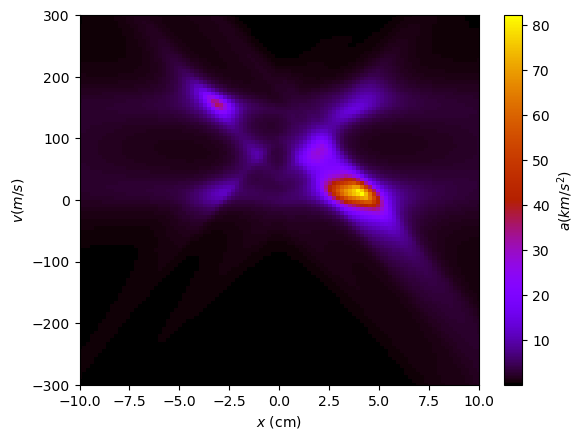

In [88]:
rateeq = pylcp.rateeq(Slower(-k*100/Hz_unit,0,0.3,2*np.pi*205e6/Hz_unit), mag_field, hamiltonian,include_mag_forces=False)

r = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-300/velocity_unit, 300/velocity_unit, 100)

R, V = np.meshgrid(r, v)
rateeq.generate_force_profile([np.zeros(R.shape), np.zeros(R.shape), R],
                           [np.zeros(V.shape), np.zeros(V.shape), V],
                           name='Frad', progress_bar=True)

fig, ax = plt.subplots(1, 1)
colormesh = ax.pcolormesh(R*cm_unit, V*velocity_unit, -rateeq.profile['Frad'].F[2]*F_unit*1e-3/(46*1.66e-27), cmap = 'gnuplot')
cb1 = plt.colorbar(colormesh)
cb1.set_label('$a(km/s^2)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v(m/s)$')
fig.subplots_adjust(left=0.12,right=0.9)
ax.set_xlim([-10,10])
ax.set_ylim([-300,300])

c:\Users\LP618\Anaconda3\lib\site-packages\pylcp-1.0.2-py3.9.egg\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part
  self.Rijl[key][ll] = gamma*intensity/2*\


Completed in 1.31 s.                                               


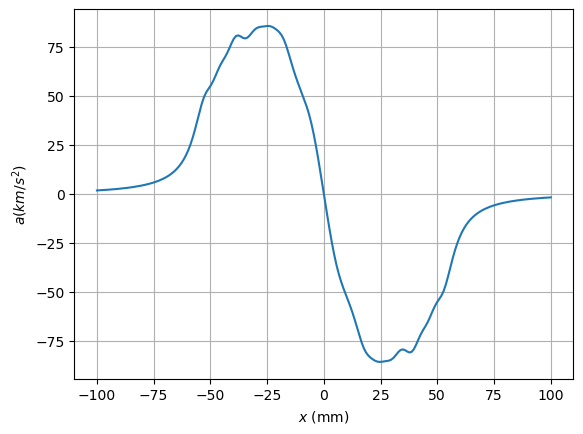

In [47]:
rateeq = pylcp.rateeq(MOT_and_Slow_Beams(-0.3*gamma/Hz_unit,0,1,2*np.pi*205e6/Hz_unit), mag_field, hamiltonian,include_mag_forces=False)

R = np.linspace(-10/cm_unit, 10/cm_unit, 200)
v = np.linspace(-150/velocity_unit, 150/velocity_unit, 600)

rateeq.generate_force_profile([R,np.zeros(R.shape),np.zeros(R.shape)],
                              [np.zeros(R.shape),np.zeros(R.shape),np.zeros(R.shape)],
                           name='Frad', progress_bar=True)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(R*cm_unit*10, rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$x$ (mm)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

In [114]:
205e6/4.4e6

46.59090909090909

In [25]:
zeemanMag = pylcp.magField(lambda R, t: np.array([-80,0,0] if R[0]*cm_unit > -4 else [1e-4,0,0])*(R[0]*cm_unit+4)*1e-4*HzperT_unit/Hz_unit)

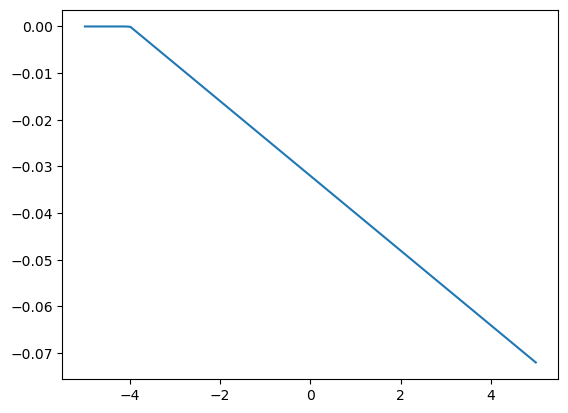

In [78]:
xs = np.linspace(-5,5,100)
plt.plot(xs,[zeemanMag.Field([x/cm_unit,0,0],0)[0]*Hz_unit/HzperT_unit for x in xs])

Completed in 41.71 s.                                               
Completed in 12.48 s.                                               
Completed in 12.05 s.                                               
Completed in 5:16.                                                  
Completed in 5:49.                                                  
Completed in 5:19.                                                  
Completed in 5:46.                                                  
Completed in 5:18.                                                  
Completed in 5:23.                                                  
Completed in 5:07.                                                  
Completed in 5:12.                                                  
Completed in 5:33.                                                  
Completed in 4:51.                                                  
Completed in 2:51.                                                  
Completed in 2:59.                

(-300.0, 300.0)

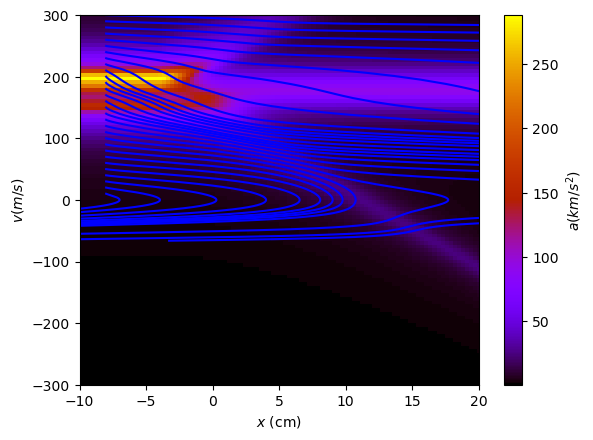

In [82]:
rateeq = pylcp.rateeq(StefanSlower(-k*150/Hz_unit,0,0.3,2*np.pi*205e6/Hz_unit), zeemanMag, hamiltonian,include_mag_forces=False)

r = np.linspace(-10/cm_unit, 20/cm_unit, 100)
v = np.linspace(-300/velocity_unit, 300/velocity_unit, 100)

R, V = np.meshgrid(r, v)
rateeq.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True)


angle = 0
vs = np.linspace(10,300,30)
sols = []
for vel in vs:
    rateeq.set_initial_position_and_velocity(np.array([-8/cm_unit, 0., 0.]),np.array([vel*np.cos(np.radians(angle))/velocity_unit, vel*np.sin(np.radians(angle))/velocity_unit, 0.]))
    rateeq.set_initial_pop(np.concatenate(([1./36]*36,[0]*72)))
    rateeq.evolve_motion([0., 5e-2/t_unit], progress_bar=True, max_step = 10e-5/t_unit, rtol=1e-3, atol=np.concatenate(([1e-3]*108,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit])),method="Radau")
    sols.append(rateeq.sol)

fig, ax = plt.subplots(1, 1)
colormesh = ax.pcolormesh(R*cm_unit, V*velocity_unit, -rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27), cmap = 'gnuplot')
[ax.plot(sol.r[0]*cm_unit,sol.v[0]*velocity_unit,'b-') for sol in sols]
cb1 = plt.colorbar(colormesh)
cb1.set_label('$a(km/s^2)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v(m/s)$')
fig.subplots_adjust(left=0.12,right=0.9)
ax.set_xlim([-10,20])
ax.set_ylim([-300,300])

In [37]:
rateeq = pylcp.rateeq({
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':1, 'delta':-200*k/Hz_unit, 's':0.3, 'wb':1/cm_unit}
    ], beam_type=pylcp.gaussianBeam)}, zeemanMag, hamiltonian,include_mag_forces=False)

r = np.linspace(-10/cm_unit, 20/cm_unit, 100)
v = np.linspace(-300/velocity_unit, 300/velocity_unit, 100)

R, V = np.meshgrid(r, v)
rateeq.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True)


angle = 0
vs = np.linspace(10,300,30)
sols = []
for vel in vs:
    rateeq.set_initial_position_and_velocity(np.array([-8/cm_unit, 0., 0.]),np.array([vel*np.cos(np.radians(angle))/velocity_unit, vel*np.sin(np.radians(angle))/velocity_unit, 0.]))
    rateeq.set_initial_pop(np.concatenate(([1./36]*36,[0]*36)))
    rateeq.evolve_motion([0., 5e-2/t_unit], progress_bar=True, max_step = 10e-5/t_unit, rtol=1e-3, atol=np.concatenate(([1e-3]*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit])),method="Radau")
    sols.append(rateeq.sol)

fig, ax = plt.subplots(1, 1)
colormesh = ax.pcolormesh(R*cm_unit, V*velocity_unit, -rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27), cmap = 'gnuplot')
[ax.plot(sol.r[0]*cm_unit,sol.v[0]*velocity_unit,'b-') for sol in sols]
cb1 = plt.colorbar(colormesh)
cb1.set_label('$a(km/s^2)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v(m/s)$')
fig.subplots_adjust(left=0.12,right=0.9)
ax.set_xlim([-10,20])
ax.set_ylim([-300,300])

c:\Users\LP618\Anaconda3\lib\site-packages\pylcp-1.0.2-py3.9.egg\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part
  self.Rijl[key][ll] = gamma*intensity/2*\


Completed in 24.08 s.                                               
Completed in 37.30 s.                                               
Completed in 33.96 s.                                               
Completed in 28.03 s.                                               
Completed in 25.98 s.                                               
Completed in 22.79 s.                                               
Completed in 25.63 s.                                               
Completed in 24.78 s.                                               
Completed in 20.85 s.                                               


Completed in 21.10 s.                                               
Completed in 4.56 s.                                               
Completed in 4.79 s.                                               
Completed in 4.62 s.                                               
Completed in 4.46 s.                                               
Completed in 4.82 s.                                               
Completed in 4.81 s.                                               
Completed in 5.06 s.                                               
Completed in 5.40 s.                                               


(-300.0, 300.0)

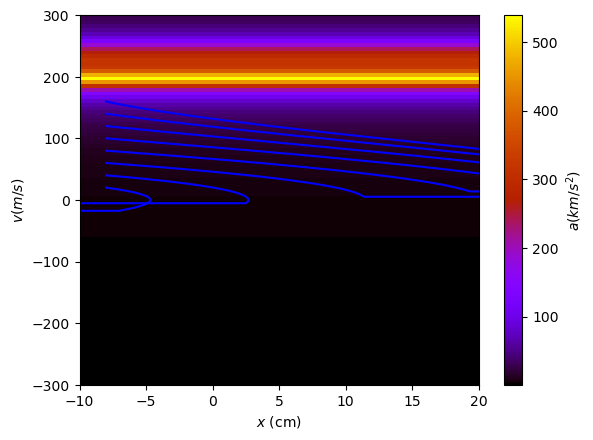

In [36]:
def BerlinChrp(*args):
    return {
    'X(v=0)->A(v=0)' : pylcp.laserBeams([
        {'kvec':np.array([-1., 0., 0.])*ksim, 'pol':np.array([0,1,0]), 'delta' : lambda t : (np.min([-150+50*t*t_unit/0.006,0]))*k/Hz_unit, 's': lambda t : 0 if t > 6e-3/t_unit else 2*0.100/np.pi/(0.003**2)/I_sat, 'wb':0.3/cm_unit}
    ], beam_type=pylcp.gaussianBeam)
    }
rateeq = pylcp.rateeq(BerlinChrp(), no_mag_field, hamiltonian,include_mag_forces=False)

r = np.linspace(-10/cm_unit, 20/cm_unit, 100)
v = np.linspace(-300/velocity_unit, 300/velocity_unit, 100)

R, V = np.meshgrid(r, v)
rateeq.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True)


angle = 0
vs = np.linspace(20,160,8)
sols = []
for vel in vs:
    rateeq.set_initial_position_and_velocity(np.array([-8/cm_unit, 0., 0.]),np.array([vel*np.cos(np.radians(angle))/velocity_unit, vel*np.sin(np.radians(angle))/velocity_unit, 0.]))
    rateeq.set_initial_pop(np.concatenate(([1./36]*36,[0]*36)))
    rateeq.evolve_motion([0., 5e-2/t_unit], progress_bar=True, max_step = 10e-5/t_unit, rtol=1e-3, atol=np.concatenate(([1e-3]*72,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-3/cm_unit,1e-3/cm_unit,1e-3/cm_unit])),method="Radau")
    sols.append(rateeq.sol)

fig, ax = plt.subplots(1, 1)
colormesh = ax.pcolormesh(R*cm_unit, V*velocity_unit, -rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27), cmap = 'gnuplot')
[ax.plot(sol.r[0]*cm_unit,sol.v[0]*velocity_unit,'b-') for sol in sols]
cb1 = plt.colorbar(colormesh)
cb1.set_label('$a(km/s^2)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v(m/s)$')
fig.subplots_adjust(left=0.12,right=0.9)
ax.set_xlim([-10,20])
ax.set_ylim([-300,300])

In [49]:
obe = pylcp.obe(lambdaLasers(-1*gammasim), mag_field, hamiltonian,include_mag_forces=False, transform_into_re_im=True)

KeyboardInterrupt: 

Completed in 10.38 s.                                              


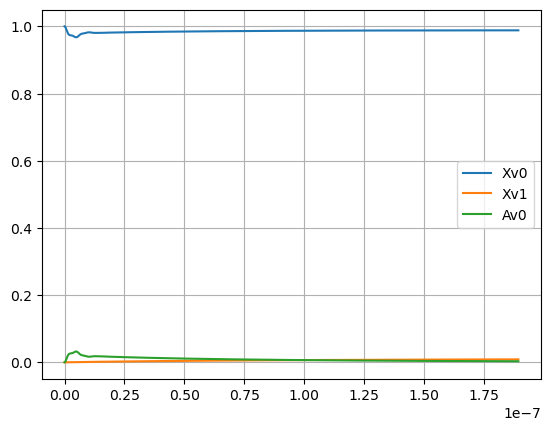

In [32]:
_diag = lambda x : np.array([x[i,i] for i in range(x.shape[0])])
obe.set_initial_position_and_velocity([0,0,0],[0,0,0])
obe.set_initial_rho_from_populations(np.concatenate([[0]*3,[1,1,1,1,1],[0]*100]))
obe.evolve_density([0,100/gamma/t_unit],progress_bar= True, max_step=1e-10/t_unit, rtol=1e-5)

fig, ax = plt.subplots(1, 1)
ax.plot(obe.sol.t*t_unit, np.sum(_diag(obe.sol.rho)[0:36],axis=0),label="Xv0")
ax.plot(obe.sol.t*t_unit, np.sum(_diag(obe.sol.rho)[36:72],axis=0),label="Xv1")
ax.plot(obe.sol.t*t_unit, np.sum(_diag(obe.sol.rho)[72:-1],axis=0),label="Av0")
plt.legend()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

In [24]:
10/gamma

1.8947017034749444e-08

In [575]:
np.diagonal(obe.sol.rho).shape

(110, 108)

In [208]:
(0.2/(112/amu_unit))*accel_unit/30000

65.68575627065887